# Overview
[**Task 3 NLP - MIDAS@IIITD Summer Internship/RA Task 2021**](https://docs.google.com/document/d/1WQHJ2KpImvA1l5QOkLQjaECOSKMiT3jp_UKH2p1zk_c/edit) 
--- 

## About the task

This notebook was coded while I was solving the task given to me as a part of the selection process for Research Assistant at MIDAS Labs (IIIT Delhi). The task involved using the given dataset to build a model to predict the category into which a particular product would fall, using the description of the product.    

General instructions for the challenge:
> 1) Goal is to predict the product category.    
2) Description should be the main feature. Other features could be used if it improves the model.   
3) Report the accuracy and details of the models that were used.      

I was expected to provide answers to the following questions: 
> 1)  Show how you would clean and process the data.   
2) Show how you would visualize this data.   
3) Show how you would measure the accuracy of the model.  
4) What ideas do you have to improve the accuracy of the model? What other algorithms would you try?

--- 


## About the dataset

**Description**

This dataset wasa created by extraction of data from a leading Indian eCommerce store, Flipkart.com. It is a pre-crawled dataset and is a part of a bigger dataset (which containes more than 5.8 million products).


**Link to the dataset** --> https://docs.google.com/spreadsheets/d/1pLv0fNE4WHokpJHUIs-FTVnmI9STgog05e658qEON0I/edit?usp=sharing


**Content**

This dataset has following fields:
1.   product_url
2.   product_name
3.   productcategorytree
4.   pid
5.   retail_price
6.   discounted_price
7.   image
8.   isFKAdvantage_product
9.   description
10.  product_rating
11.  overall_rating
12.  brand
13.  product_specifications

---

## My Approach

My approach for tackling this challenge is based on finding a simple yet still good solution, for getting good results. The following figure depicts the approach I undertake for this challenge. 

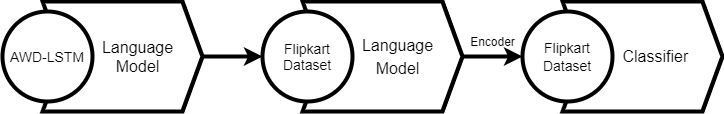

The approach shown above was introduced by [Howard and Ruder et. al.](https://arxiv.org/abs/1801.06146) in 2018. This paper provided a novel method for fine-tuning models for inductive transfer learning. This process includes using the model trained for a particular source task to be used to obtain good performance on other tasks (NLP tasks) as well, just like transfer learning in Computer Vision. 

According to the paper, language modeling is the ideal source task and is considered analogous to ImageNet for NLP tasks. The pre-training is to be done on a large corpus of the same language which is to be used in the main task (ie category prediction for our case). This helps in effectively catching the main properties and aspects of language. The pre-training is done to help the model understand the general properties and semantics of the language at hand and then the models have to be tweaked a little to suit the specific task. This would be something like the Image-Net corpus, but, for language and NLP tasks. 

We don't have to build the language model from scratch every time. It has to be performed only once. The resulting pre-trained model which we get can be reused for the next stages. I decided to use ULMFiT since it is found that pre-training was especially useful for small datasets and medium-sized datasets.

ULMFiT has revolutionized the field of NLP in the past few years, improving the scope of deep learning in NLP. It made training models in almost no time possible for various NLP tasks. This set the base for transfer learning for NLP and paved the way for ELMo, GPT, GPT-2, BERT, and XLNet.

---

# Setup
In order to setup this enviroment correctly we need to run a couple of commands.

The only thing you need is a copy of the dataset downloaded from the link mentioned above.

--- 



If you can't find the folder under "/drive/My Drive" in your Google Drive :
1.  Go to your google drive and create a folder named `IIITD Midas Labs`. 
2.  Add the dataset file inside this folder. 
3.  Right click -> Add to my Drive.   
4.  Run the cell below.  
    1. It will ask you to go to a URL and generate an Authentication token from your selected google account.     
    2. Click on on your google account and copy the token.
    3. Paste the token in the prompt. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`%matplotlib` is a [magic function](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) in IPython. Quoting the relevant documentation, magic functions are: 

> IPython has a set of predefined ‘magic functions’ that you can call with a command line style syntax. There are two kinds of magics, line-oriented and cell-oriented. Line magics are prefixed with the % character and work much like OS command-line calls: they get as an argument the rest of the line, where arguments are passed without parentheses or quotes. Lines magics can return results and can be used in the right hand side of an assignment. Cell magics are prefixed with a double %%, and they are functions that get as an argument not only the rest of the line, but also the lines below it in a separate argument.

Another magic method in IPython is `%autoreload`. Since it is not enabled by default, so it should be loaded as an extension: 

`%load_ext autoreload`

Now, turn on auto-reloading by:

`%autoreload 2`

This solves an important problem. Now each time you execute some code, IPython will reimport all the modules to make sure that you are using the latest possible versions. You will not have to do it manually. 

There are 3 configuration options available:

> 1) %autoreload 0 - disables the auto-reloading. This is the default setting.  
2) %autoreload 1 - it will only auto-reload modules that were imported using the %aimport function (e.g %aimport my_module). It’s a good option if you want to specifically auto-reload only a selected module.  
3) %autoreload 2 - auto-reload all the modules. Great way to make writing and testing your modules much easier.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Setting a couple of Global Constants at the start so that we do not have to set them again and again since they are used in many parts of the code. 

> 1) path - used to store the location of files.  
2) bs (batch size) -  refers to the number of training examples utilized in one iteration.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here, depending on your hardware.


In [ ]:
path = '/content/'

In [ ]:
bs = 32

# Imports

In [ ]:
# general
from nltk.corpus import stopwords
from fastai.text import *
import string
import re
import warnings

# data processing
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

# nltk
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')


# fastai

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the dataset


It is of paramount importance to **look at the data** which was provided, to make sure the format of data is understood, how it's stored, what type of values it holds, etc. Even if one read descriptions about the data, the actual data may be different from what was expected.

--- 

In [ ]:
df_raw = pd.read_csv(
    '/content/drive/MyDrive/IIITD Midas Labs/flipkart_com-ecommerce_sample.csv')
df_raw.head(5)

uniq_id  ...                             product_specifications
0  c2d766ca982eca8304150849735ffef9  ...  {"product_specification"=>[{"key"=>"Number of ...
1  7f7036a6d550aaa89d34c77bd39a5e48  ...  {"product_specification"=>[{"key"=>"Installati...
2  f449ec65dcbc041b6ae5e6a32717d01b  ...  {"product_specification"=>[{"key"=>"Ideal For"...
3  0973b37acd0c664e3de26e97e5571454  ...  {"product_specification"=>[{"key"=>"Number of ...
4  bc940ea42ee6bef5ac7cea3fb5cfbee7  ...  {"product_specification"=>[{"key"=>"Pet Type",...

[5 rows x 15 columns]

In [ ]:
df_raw.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [ ]:
# to make sure notebook displays all the rows
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)


# to display transpose of df
display_all(df_raw.T)

0      \
uniq_id                                   c2d766ca982eca8304150849735ffef9   
crawl_timestamp                                  2016-03-25 22:59:23 +0000   
product_url              http://www.flipkart.com/alisha-solid-women-s-c...   
product_name                           Alisha Solid Women's Cycling Shorts   
product_category_tree    ["Clothing >> Women's Clothing >> Lingerie, Sl...   
pid                                                       SRTEH2FF9KEDEFGF   
retail_price                                                           999   
discounted_price                                                       379   
image                    ["http://img5a.flixcart.com/image/short/u/4/a/...   
is_FK_Advantage_product                                              False   
description              Key Features of Alisha Solid Women's Cycling S...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                               Alisha   
product_specifications   {"product_specification"=>[{"key"=>"Number of ...   

                                                                     1      \
uniq_id                                   7f7036a6d550aaa89d34c77bd39a5e48   
crawl_timestamp                                  2016-03-25 22:59:23 +0000   
product_url              http://www.flipkart.com/fabhomedecor-fabric-do...   
product_name                           FabHomeDecor Fabric Double Sofa Bed   
product_category_tree    ["Furniture >> Living Room Furniture >> Sofa B...   
pid                                                       SBEEH3QGU7MFYJFY   
retail_price                                                         32157   
discounted_price                                                     22646   
image                    ["http://img6a.flixcart.com/image/sofa-bed/j/f...   
is_FK_Advantage_product                                              False   
description              FabHomeDecor Fabric Double Sofa Bed (Finish Co...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                         FabHomeDecor   
product_specifications   {"product_specification"=>[{"key"=>"Installati...   

                                                                     2      \
uniq_id                                   f449ec65dcbc041b6ae5e6a32717d01b   
crawl_timestamp                                  2016-03-25 22:59:23 +0000   
product_url              http://www.flipkart.com/aw-bellies/p/itmeh4grg...   
product_name                                                    AW Bellies   
product_category_tree    ["Footwear >> Women's Footwear >> Ballerinas >...   
pid                                                       SHOEH4GRSUBJGZXE   
retail_price                                                           999   
discounted_price                                                       499   
image                    ["http://img5a.flixcart.com/image/shoe/7/z/z/r...   
is_FK_Advantage_product                                              False   
description              Key Features of AW Bellies Sandals Wedges Heel...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                                   AW   
product_specifications   {"product_specification"=>[{"key"=>"Ideal For"...   

                                                                     3      \
uniq_id                                   0973b37acd0c664e3de26e97e5571454   
crawl_timestamp                                  2016-03-25 22:59:23 +0000   
product_url              http://www.flipkart.com/alisha-solid-women-s-c...   
product_na

# Exploratory Data Analysis

## Statistical summary of the data

In [ ]:
# to see the statistical summary of columns in dataset
display_all(df_raw.describe(include='all').T)

count unique  \
uniq_id                  20000  20000   
crawl_timestamp          20000    371   
product_url              20000  20000   
product_name             20000  12676   
product_category_tree    20000   6466   
pid                      20000  19998   
retail_price             19922    NaN   
discounted_price         19922    NaN   
image                    19997  18589   
is_FK_Advantage_product  20000      2   
description              19998  17539   
product_rating           20000     36   
overall_rating           20000     36   
brand                    14136   3499   
product_specifications   19986  18825   

                                                                       top  \
uniq_id                                   a921091c5367be5a9dd7e64cdaecab00   
crawl_timestamp                                  2015-12-01 12:40:44 +0000   
product_url              http://www.flipkart.com/aj-dezines-boy-s-kurta...   
product_name                    TheLostPuppy Back Cover for Apple iPad Air   
product_category_tree     ["Jewellery >> Necklaces & Chains >> Necklaces"]   
pid                                                       JEAEGE8Q8GXYFTGU   
retail_price                                                           NaN   
discounted_price                                                       NaN   
image                    ["http://img6a.flixcart.com/image/car-mat/m/t/...   
is_FK_Advantage_product                                              False   
description              TheLostPuppy Back Cover for Apple iPad Air (Mu...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                          Allure Auto   
product_specifications   {"product_specification"=>[{"key"=>"Type", "va...   

                          freq     mean      std  min  25%   50%   75%     max  
uniq_id                      1      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
crawl_timestamp           1979      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
product_url                  1      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
product_name               134      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
product_category_tree     1567      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
pid                          2      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
retail_price               NaN  2979.21  9009.64   35  666  1040  1999  571230  
discounted_price           NaN   1973.4  7333.59   35  350   550   999  571230  
image                       45      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
is_FK_Advantage_product  19215      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
description                 92      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
product_rating           18151      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
overall_rating           18151      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
brand                      469      NaN      NaN  NaN  NaN   NaN   NaN     NaN  
product_specifications      71      NaN      NaN  NaN  NaN   NaN   NaN     NaN

In [ ]:
df_raw.shape

(20000, 15)

## Finding number of null values

In [ ]:
# finding the number of null values in each column
df_raw.isnull().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 78
discounted_price             78
image                         3
is_FK_Advantage_product       0
description                   2
product_rating                0
overall_rating                0
brand                      5864
product_specifications       14
dtype: int64

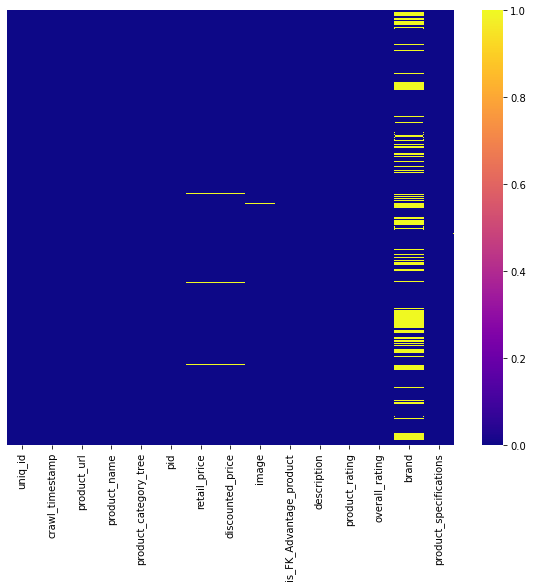

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_raw.isnull(), yticklabels=False, cmap='plasma', cbar=True)

The above graph depicts that there are a lot of null values in the "brand" column. 

## Finding top 20 brands

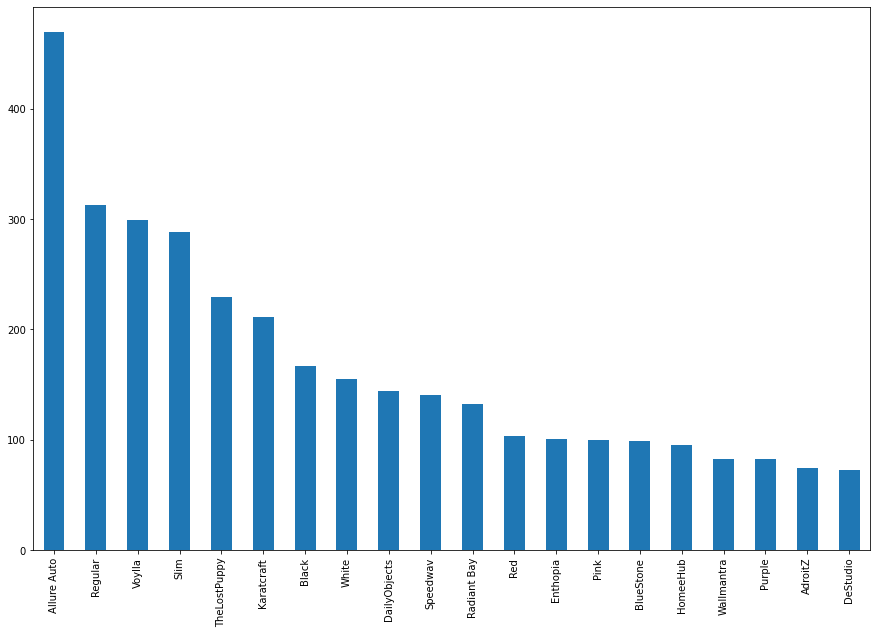

In [ ]:
# plotting the no of occurances of 20 most frequent brands
df_raw['brand'].value_counts().nlargest(20).plot(kind='bar', figsize=(15, 10))

# Data cleaning

## Selecting the relevant categories

As per the instructions given in the task, 'description' is to be considered as the main feature for category prediction. However, I have also kept 'product_name' and 'brand' since I wanted to experiment and find if adding those features help the model predict better or not. These features might prove to be useful since you can often narrow down to a few categories based on the brand and product name. For eg, a product from nike is likely to fall under 'Footwear' or 'Clothing' and not under 'Furniture'. 

---

In [ ]:
columns = ['description', 'product_category_tree', 'product_name', 'brand']

In [ ]:
df = df_raw[columns]
df.head(5)

description  ...         brand
0  Key Features of Alisha Solid Women's Cycling S...  ...        Alisha
1  FabHomeDecor Fabric Double Sofa Bed (Finish Co...  ...  FabHomeDecor
2  Key Features of AW Bellies Sandals Wedges Heel...  ...            AW
3  Key Features of Alisha Solid Women's Cycling S...  ...        Alisha
4  Specifications of Sicons All Purpose Arnica Do...  ...        Sicons

[5 rows x 4 columns]

## Dropping rows where description is missing

In [ ]:
df['description'].isnull().sum()

2

In [ ]:
df[df['description'].isnull()]

description  ...  brand
553           NaN  ...    NaN
17299         NaN  ...  Amore

[2 rows x 4 columns]

In [ ]:
df.dropna(axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.shape

(14135, 4)

## Splitting the "product_category_tree" into seperate categories

In [ ]:
def main_cat(value):
    try:
        return value.split('>>')[0][2:len(value.split('>>')[0])-1]
    except IndexError:
        return 'None'


def secondary_cat(value):
    try:
        return value.split('>>')[1][1:len(value.split('>>')[1])-1]
    except IndexError:
        return 'None'


def tertiary_cat(value):
    try:
        return value.split('>>')[2][1:len(value.split('>>')[2])-1]
    except IndexError:
        return 'None'


def quaternary_cat(value):
    try:
        return value.split('>>')[3][1:len(value.split('>>')[3])-1]
    except IndexError:
        return 'None'

In [ ]:
df['main_category'] = df['product_category_tree'].apply(main_cat)
df['secondary_category'] = df['product_category_tree'].apply(secondary_cat)
df['tertiary_category'] = df['product_category_tree'].apply(tertiary_cat)
df['quaternary_category'] = df['product_category_tree'].apply(quaternary_cat)

In [ ]:
df.head(5)

description  ...                                quaternary_category
0  Key Features of Alisha Solid Women's Cycling S...  ...                                             Shorts
1  FabHomeDecor Fabric Double Sofa Bed (Finish Co...  ...  FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2  Key Features of AW Bellies Sandals Wedges Heel...  ...                                        AW Bellies"
3  Key Features of Alisha Solid Women's Cycling S...  ...                                             Shorts
4  Specifications of Sicons All Purpose Arnica Do...  ...                                            Shampoo

[5 rows x 8 columns]

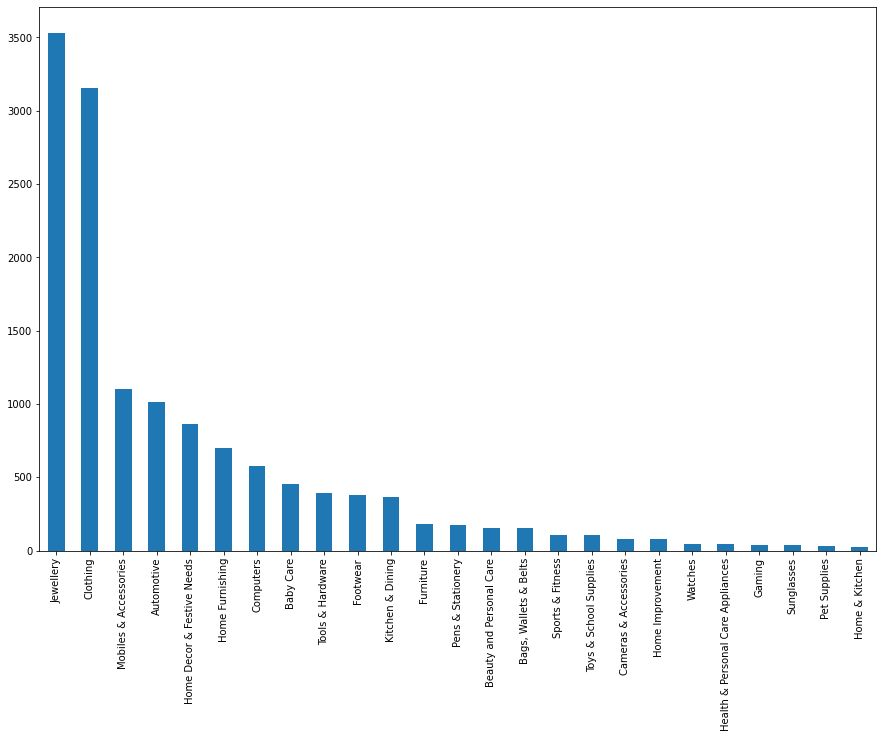

In [ ]:
df['main_category'].value_counts().nlargest(
    25).plot(kind='bar', figsize=(15, 10))

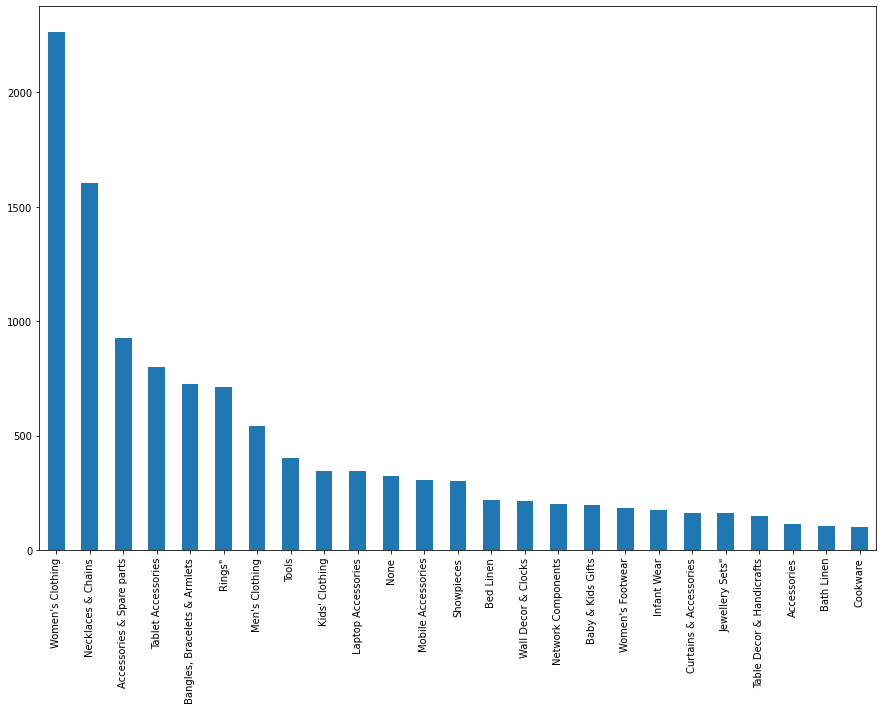

In [ ]:
df['secondary_category'].value_counts().nlargest(
    25).plot(kind='bar', figsize=(15, 10))

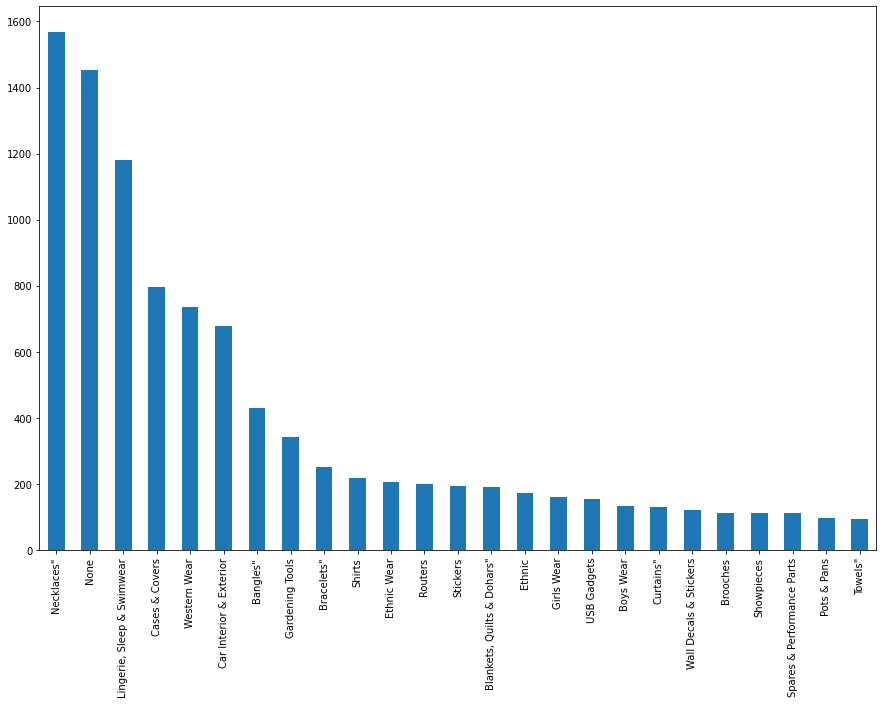

In [ ]:
df['tertiary_category'].value_counts().nlargest(
    25).plot(kind='bar', figsize=(15, 10))

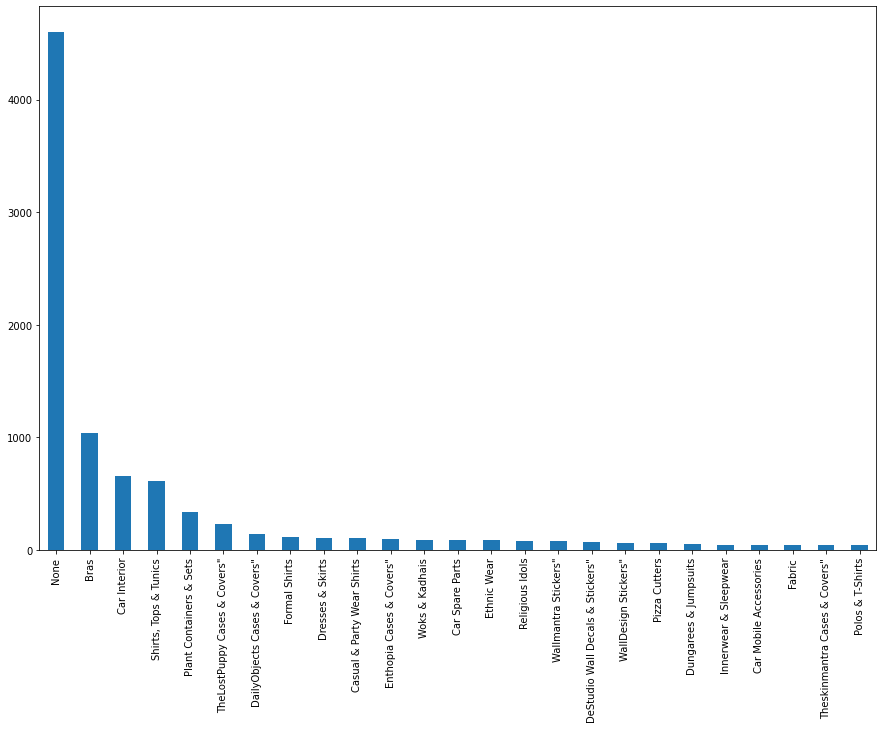

In [ ]:
df['quaternary_category'].value_counts().nlargest(
    25).plot(kind='bar', figsize=(15, 10))

## Removing the rows of categories with instances less than threshold value

I have declared a variable named "threshold_value" which is the number of instances of the category below which the category should be dropped. For example, if threshold_value = 10 then all the categories having less than 10 instances or data points will be dropped. this is done to check if the accuracy gets better for lesser and more frequent categories or not. For this purpose, I have chosen threshold_values as 100, 30 and 10. 

--- 

Threshold_value = 10 seems to be the right choice because categories having less than 10 instances are very specific and have less data points which might hamper the accuracy of the classifier. I have shown the table of categories falling under this segregation which clearly depicts that those categories are highly specific. For example,  "883 Police Full Sleeve Solid Men's Jacket" and "ANAND ARCHIES Girls Flats" to name a few. 

---

In [ ]:
threshold_value = 10

In [ ]:
main_cats_ = df.groupby('main_category').agg({'main_category': ['count']})
main_cats_

main_category
                                                           count
main_category                                                   
883 Police Full Sleeve Solid Men's Jacket"                     1
ABEEZ Boys, Men, Girls (Black, Pack of 1)"                     1
ANAND ARCHIES Girls Flats"                                     2
ANAND ARCHIES Girls Wedges"                                    1
ANASAZI Casual 3/4 Sleeve Solid Women's Top"                   1
...                                                          ...
run of luck Solid Women's Round Neck Dark Blue ...             1
soie Fashion Women's Full Coverage Bra"                        1
soie Fashion Women's Sports Bra"                               1
tadd Men's, Women's Ankle Length Socks"                        1
xy decor Cotton Sofa Cover (white Pack of 6)"                  1

[264 rows x 1 columns]

In [ ]:
main_cats_.columns = ['_' .join(column) for column in main_cats_.columns]
main_cats_.columns

Index(['main_category_count'], dtype='object')

In [ ]:
top_cats = main_cats_[main_cats_['main_category_count'] > threshold_value].sort_values(
    by='main_category_count', ascending=False)
top_cats

main_category_count
main_category                                         
Jewellery                                         3531
Clothing                                          3153
Mobiles & Accessories                             1099
Automotive                                        1012
Home Decor & Festive Needs                         863
Home Furnishing                                    699
Computers                                          577
Baby Care                                          457
Tools & Hardware                                   391
Footwear                                           377
Kitchen & Dining                                   365
Furniture                                          180
Pens & Stationery                                  174
Beauty and Personal Care                           156
Bags, Wallets & Belts                              151
Sports & Fitness                                   108
Toys & School Supplies                             103
Cameras & Accessories                               82
Home Improvement                                    81
Watches                                             48
Health & Personal Care Appliances                   43
Sunglasses                                          35
Gaming                                              35
Pet Supplies                                        30
Home & Kitchen                                      24
Home Entertainment                                  19

main_category_count    13793
dtype: int64


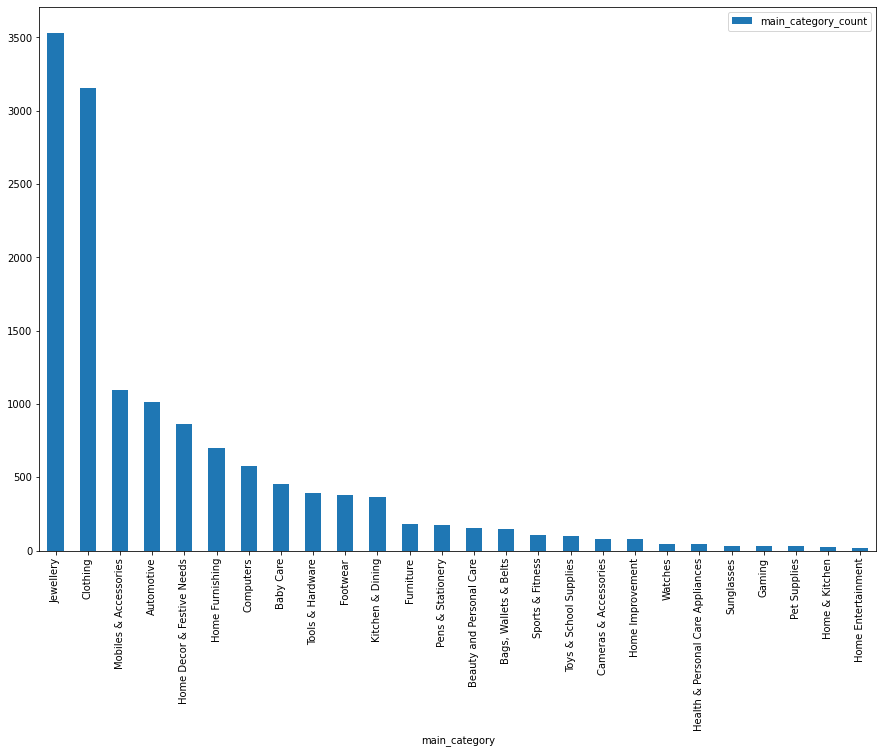

In [ ]:
print(top_cats.sum())
top_cats.plot(kind='bar', figsize=(15, 10))

In [ ]:
other_cats = main_cats_[main_cats_['main_category_count'] < threshold_value].sort_values(
    by='main_category_count', ascending=False)
other_cats

main_category_count
main_category                                                          
Clovia Women's Full Coverage Bra"                                     9
Vishudh Printed Women's Straight Kurta"                               8
Lilliput Top Baby Girl's  Combo"                                      8
Olvin Aviator Sunglasses"                                             7
Clovia Women's T-Shirt Bra"                                           6
...                                                                 ...
Kraft Seeds Rosemary Herb (Pack Of 5) Seed (75 ...                    1
Kraft Seeds Thyme Herbs Seed (200 per packet)"                        1
LGRL Women's Leggings"                                                1
Laser X Checkered Men's Boxer (Pack of 4)"                            1
xy decor Cotton Sofa Cover (white Pack of 6)"                         1

[237 rows x 1 columns]

(237, 1)


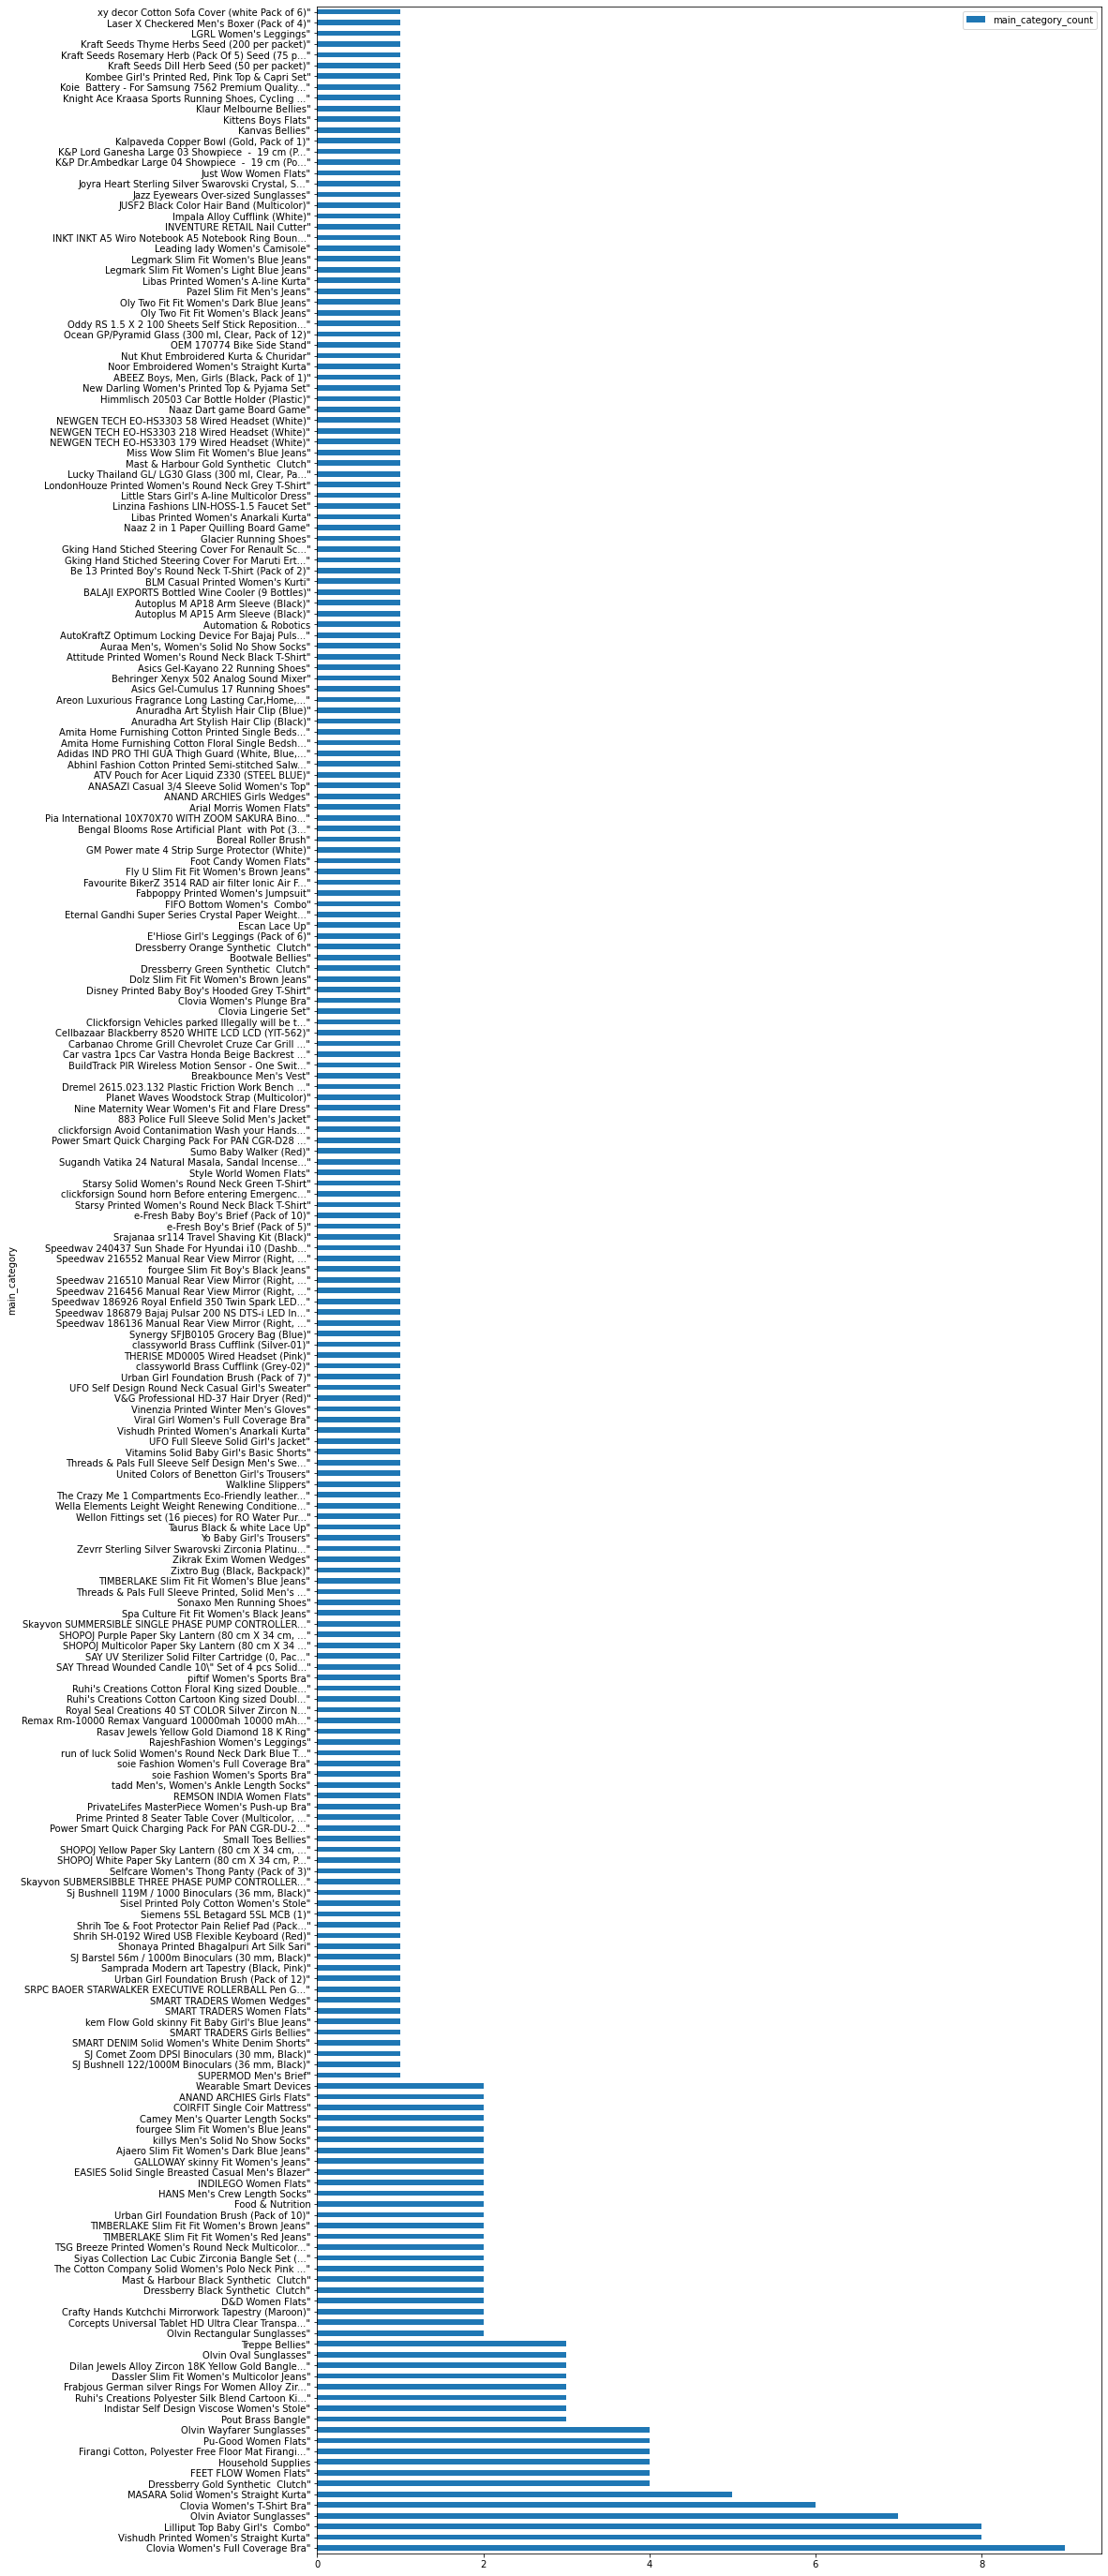

In [ ]:
print(other_cats.shape)
other_cats.plot(kind='barh', figsize=(15, 50))

In [ ]:
# finding the list of categories with less instances than the threshold_value

cats = []

for i in range(len(df)):
    cat = df['main_category'].iloc[i]
    vals = (df['main_category'] == cat).sum()
    if vals < threshold_value:
        cats.append(cat)

list_unique_cats = list(set(cats))
len(list_unique_cats)

237

In [ ]:
# finding the rows having the categories present in "cats" and dropping them

arr = []

for i in range(len(df)):
    if df['main_category'].iloc[i] in list_unique_cats:
        arr.append(i)

df_final = df.drop(arr)

## After removing the rows

In [ ]:
df_final.shape

(13803, 8)

# Data Preprocessing

In order to clean the data, I have removed all the special characters, links, numbers and other type of symbols which are not small or capital alphabest. This is done to shorten the length of the description by removing thing which might be of the least relevance in  predicting the category of the product. Thus, I have cleand the text by retaining only alphabets and removing everything else.


In [ ]:
df_final['description'] = df_final['description'].str.replace("[^a-zA-Z]", " ")

In the next step of processing, that is **Tokenization**, I split the raw sentences into words, or more exactly tokens. The easiest way to do this is to split the string on spaces, which is what i have done since the key-words present in the description matter the most in category predicting and it has nothing to do with semantic properties. Infact, the description is in buller points for some instances and is not written in proper english (rather key words are mentioned). Which is why I chose to split words on spaces. 

However, a better way to do the splitting for other tasks would be:

- taking care of punctuations 
- some words are contractions of two different words, like isn't or don't  
- cleaning some parts of our texts, if there's HTML code for instance or an embedded link

Since this is not required here, I chose the method which takes less computational power and is simpler.

In [ ]:
# tokenization
tokenized_doc = df_final['description'].apply(lambda x: x.split())

Now, I got rid of the stopwords from the text data. Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document. Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc. I have used the stopwords for nltk package which I have downloaded in the "Setup" section.

In [ ]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(
    lambda x: [item for item in x if item not in stop_words])
tokenized_doc.iloc[1]

['FabHomeDecor',
 'Fabric',
 'Double',
 'Sofa',
 'Bed',
 'Finish',
 'Color',
 'Leatherette',
 'Black',
 'Mechanism',
 'Type',
 'Pull',
 'Out',
 'Price',
 'Rs',
 'Fine',
 'deep',
 'seating',
 'experience',
 'Save',
 'Space',
 'new',
 'click',
 'clack',
 'Sofa',
 'Bed',
 'Easy',
 'fold',
 'vice',
 'versa',
 'simple',
 'click',
 'clack',
 'mechanism',
 'Chrome',
 'legs',
 'mango',
 'wood',
 'frame',
 'long',
 'term',
 'durability',
 'Double',
 'cushioned',
 'Sofa',
 'Bed',
 'provide',
 'extra',
 'softness',
 'make',
 'fine',
 'seating',
 'experience',
 'A',
 'double',
 'bed',
 'easily',
 'sleep',
 'two',
 'Specifications',
 'FabHomeDecor',
 'Fabric',
 'Double',
 'Sofa',
 'Bed',
 'Finish',
 'Color',
 'Leatherette',
 'Black',
 'Mechanism',
 'Type',
 'Pull',
 'Out',
 'Installation',
 'Demo',
 'Installation',
 'Demo',
 'Details',
 'Installation',
 'demo',
 'product',
 'done',
 'free',
 'cost',
 'part',
 'purchase',
 'Our',
 'service',
 'partner',
 'visit',
 'location',
 'within',
 'business',

In [ ]:
# de-tokenization
detokenized_doc = []
for i in range(len(df_final)):
    t = ' '.join(tokenized_doc.iloc[i])
    detokenized_doc.append(t)

In [ ]:
df_final['description'] = detokenized_doc

In [ ]:
df_final['description'][1]

'FabHomeDecor Fabric Double Sofa Bed Finish Color Leatherette Black Mechanism Type Pull Out Price Rs Fine deep seating experience Save Space new click clack Sofa Bed Easy fold vice versa simple click clack mechanism Chrome legs mango wood frame long term durability Double cushioned Sofa Bed provide extra softness make fine seating experience A double bed easily sleep two Specifications FabHomeDecor Fabric Double Sofa Bed Finish Color Leatherette Black Mechanism Type Pull Out Installation Demo Installation Demo Details Installation demo product done free cost part purchase Our service partner visit location within business hours delivery product In The Box Sofa Bed General Brand FabHomeDecor Mattress Included No Delivery Condition Knock Down Storage Included No Mechanism Type Pull Out Type Sofa Bed Style Contemporary Modern Filling Material Microfiber Seating Capacity Seater Upholstery Type NA Upholstery Included No Bed Size Double Shape Square Suitable For Living Room Model Number FHD 

In [ ]:
len(df_final['main_category'].unique())

27

In [ ]:
df_final.head(5)

description  ...                                quaternary_category
0  Key Features Alisha Solid Women Cycling Shorts...  ...                                             Shorts
1  FabHomeDecor Fabric Double Sofa Bed Finish Col...  ...  FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2  Key Features AW Bellies Sandals Wedges Heel Ca...  ...                                        AW Bellies"
3  Key Features Alisha Solid Women Cycling Shorts...  ...                                             Shorts
4  Specifications Sicons All Purpose Arnica Dog S...  ...                                            Shampoo

[5 rows x 8 columns]

In [ ]:
df_final.to_csv('/content/df_nlp.csv')

# ULMFiT using description to predict main_category with threshold value=0 (all categories)

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
1  FabHomeDecor Fabric Double Sofa Bed Finish Col...  ...     Furniture
2  Key Features AW Bellies Sandals Wedges Heel Ca...  ...      Footwear
3  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
4  Specifications Sicons All Purpose Arnica Dog S...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Amita Home Furnishing Cotton Printed Single Beds...", Shrih SH-0192 Wired USB Flexible Keyboard (Red)", SMART DENIM Solid Women's White Denim Shorts", UFO Full Sleeve Solid Girl's Jacket", Cellbazaar Blackberry 8520 WHITE LCD LCD (YIT-562)"...
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a li

## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


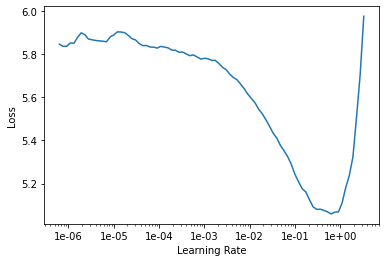

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12722 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 6min 13s, sys: 4min 36s, total: 10min 49s
Wall time: 10min 55s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12722 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12722 items)
x: TextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


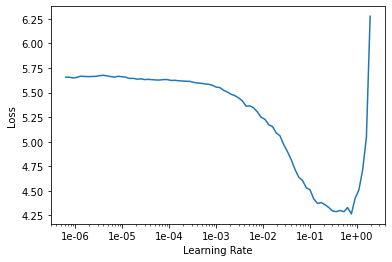

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

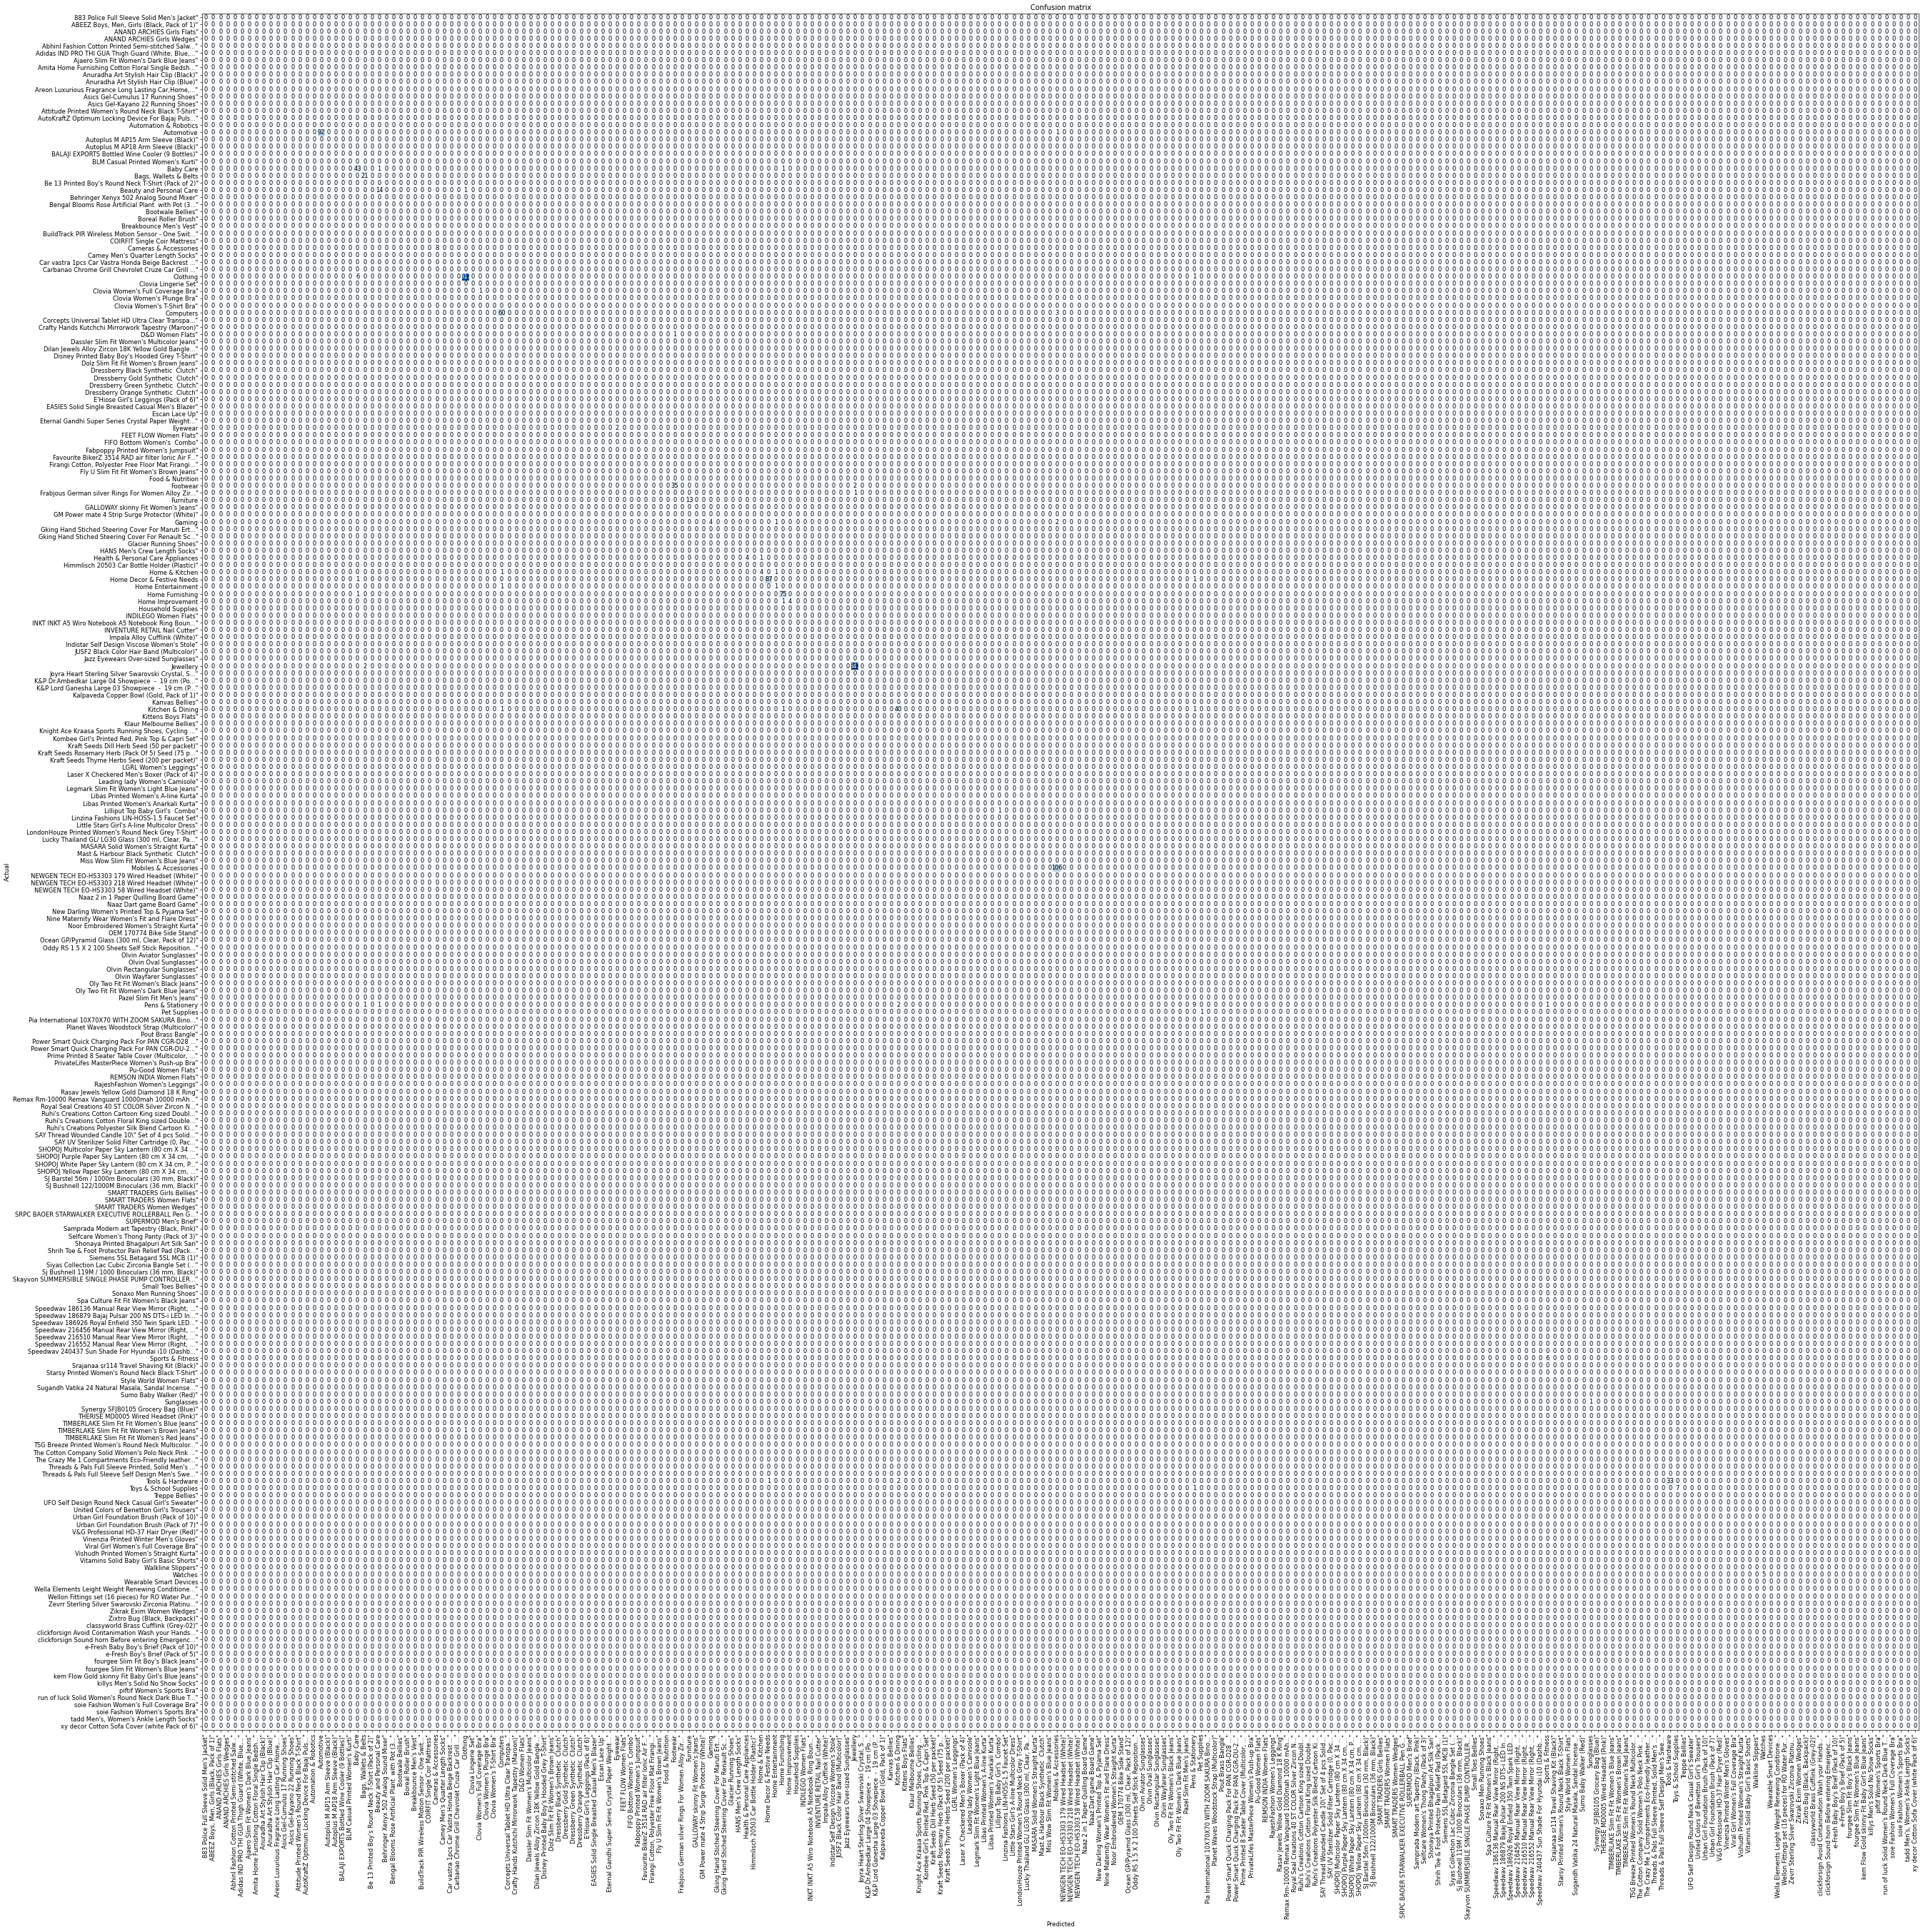

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(45, 45), dpi=60)

# ULMFiT using description to predict main_category with threshold value=10

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
1  FabHomeDecor Fabric Double Sofa Bed Finish Col...  ...     Furniture
2  Key Features AW Bellies Sandals Wedges Heel Ca...  ...      Footwear
3  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
4  Specifications Sicons All Purpose Arnica Dog S...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations. 


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


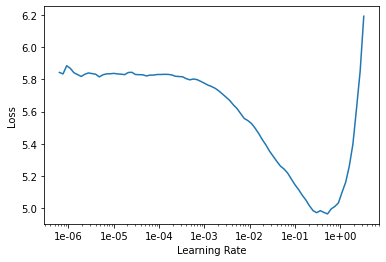

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12423 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 5min 59s, sys: 4min 25s, total: 10min 25s
Wall time: 10min 31s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12423 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12423 items)
x: TextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


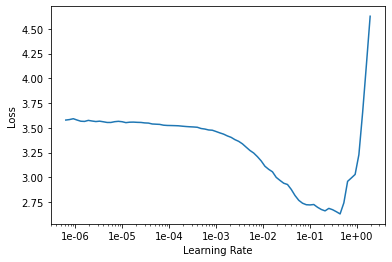

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

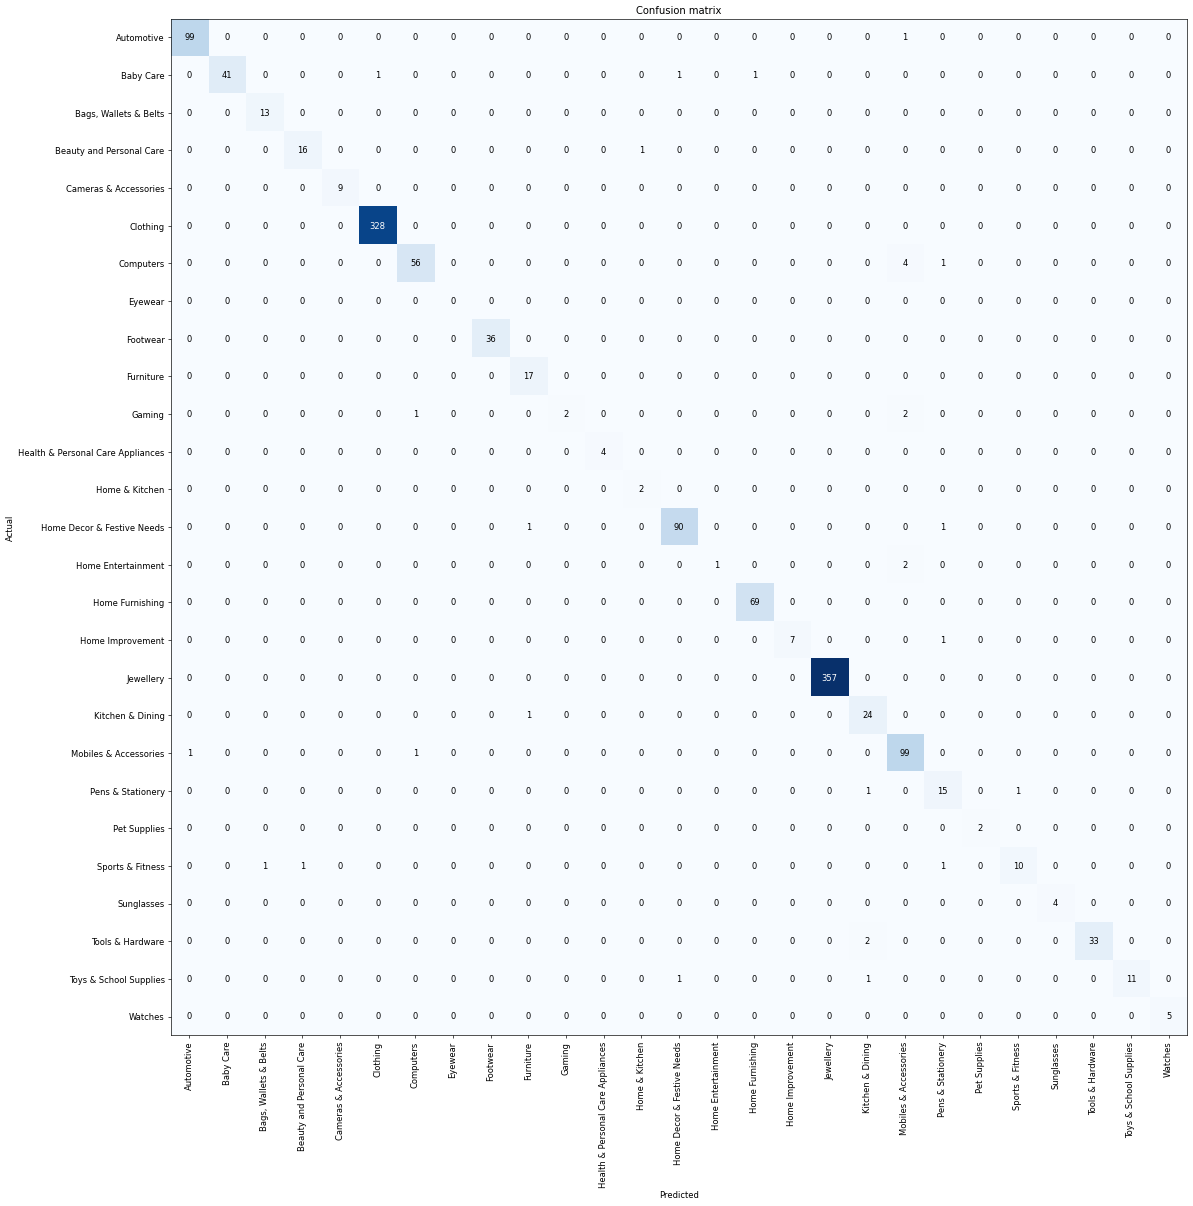

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(20, 20), dpi=60)

# ULMFiT using description to predict main_category with threshold value=30

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
1  FabHomeDecor Fabric Double Sofa Bed Finish Col...  ...     Furniture
2  Key Features AW Bellies Sandals Wedges Heel Ca...  ...      Footwear
3  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
4  Specifications Sicons All Purpose Arnica Dog S...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations. 


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


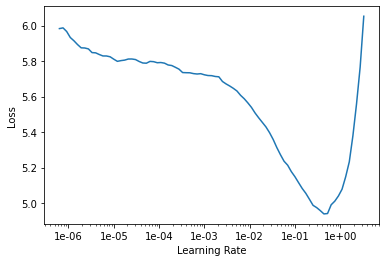

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12375 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 5min 55s, sys: 4min 21s, total: 10min 16s
Wall time: 10min 22s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12375 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12375 items)
x: TextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


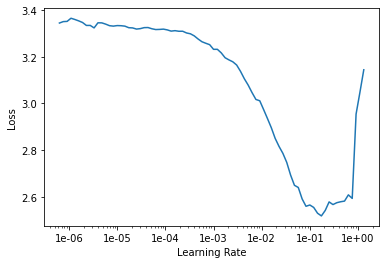

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

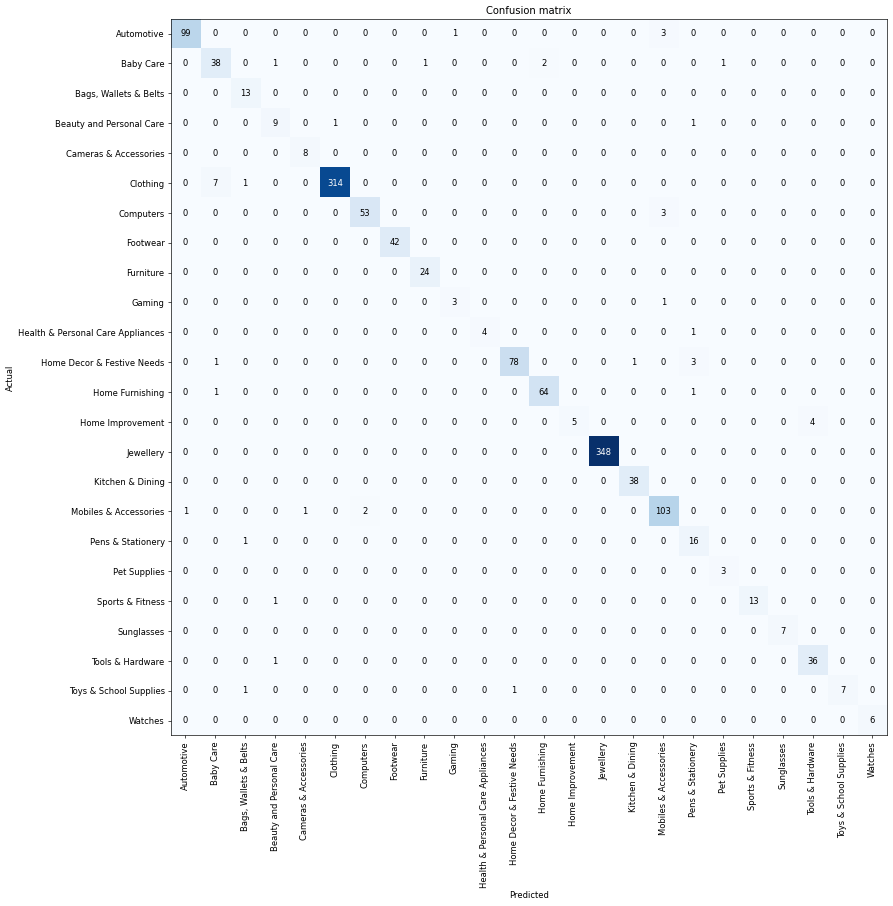

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

# ULMFiT using description to predict main_category with threshold value=100

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
1  FabHomeDecor Fabric Double Sofa Bed Finish Col...  ...     Furniture
2  Key Features AW Bellies Sandals Wedges Heel Ca...  ...      Footwear
3  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
6  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


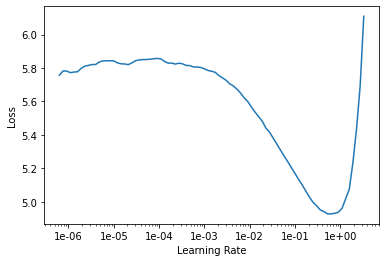

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12057 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 5min 43s, sys: 4min 12s, total: 9min 55s
Wall time: 10min 1s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12057 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12057 items)
x: TextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


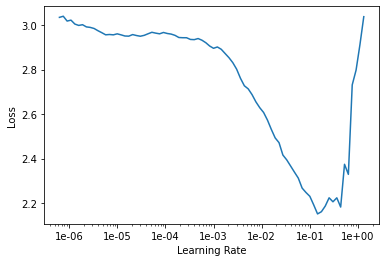

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

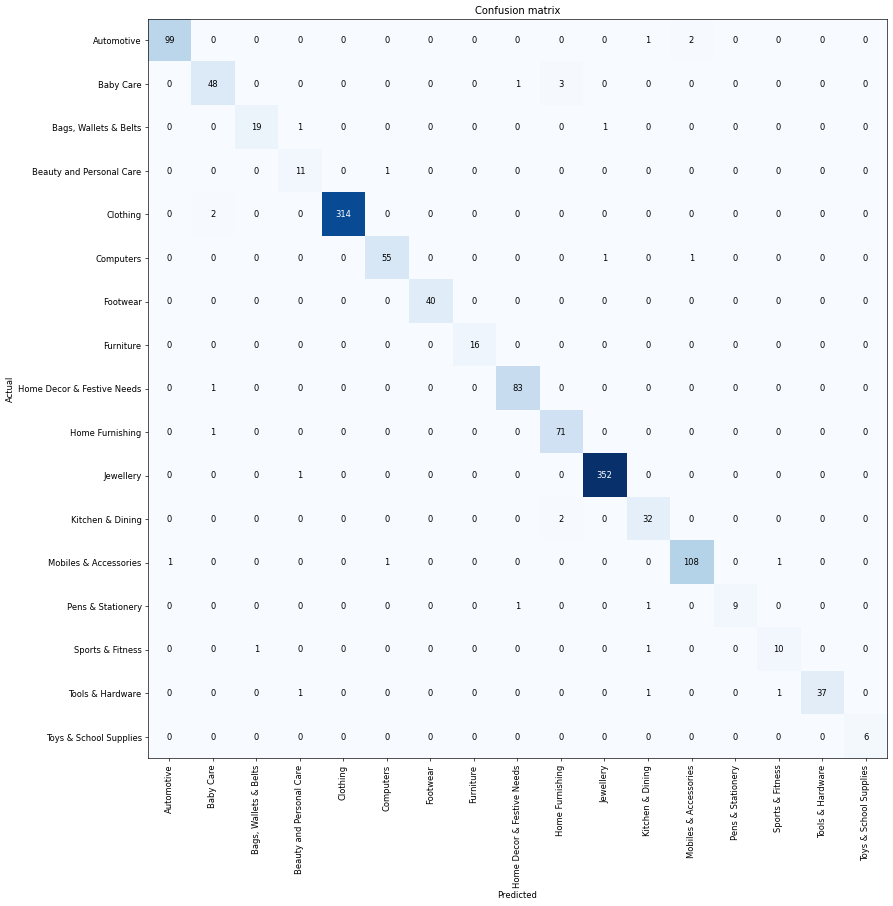

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

# ULMFiT using description, brand and product_name to predict main_category with threshold value=0

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
list_top_cats = ['Jewellery', 'Clothing']
arr = []

for i in range(len(df_final)):
    if df_final['main_category'].iloc[i] in list_top_cats:
        arr.append(i)

print(arr)
df = df_final.drop(arr)

[0, 3, 6, 9, 11, 13, 15, 18, 21, 22, 26, 30, 32, 34, 54, 74, 81, 82, 83, 84, 85, 86, 87, 92, 94, 96, 100, 101, 111, 112, 114, 116, 117, 118, 127, 147, 152, 153, 154, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227, 228, 229, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 306, 307, 308, 309, 310, 311, 312, 313, 325, 329, 344, 357, 358, 361, 363, 364, 367, 370, 382, 385, 387, 388, 389, 390, 397, 400, 401, 402, 407, 410, 411, 414, 416, 417, 422, 425, 427, 429, 430, 431, 433, 436, 437, 438,

In [ ]:
df.shape

(7451, 8)

## Adding brand and product_name to the description

In [ ]:
for i in range(len(df_final)):
    df_final['description'].iloc[i] = "Product name is " + str(df_final['product_name'].iloc[i]) + " " + "Brand name is " + str(
        df_final['brand'].iloc[i]) + " " + str(df_final['description'].iloc[i])

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
1  Product name is FabHomeDecor Fabric Double Sof...  ...     Furniture
2  Product name is AW Bellies Brand name is AW Ke...  ...      Footwear
3  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
4  Product name is Sicons All Purpose Arnica Dog ...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Yo Baby Girl's Trousers", Foot Candy Women Flats", Arial Morris Women Flats", ATV Pouch for Acer Liquid Z330 (STEEL BLUE)", Taurus Black & white Lace Up"...
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

In [ ]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

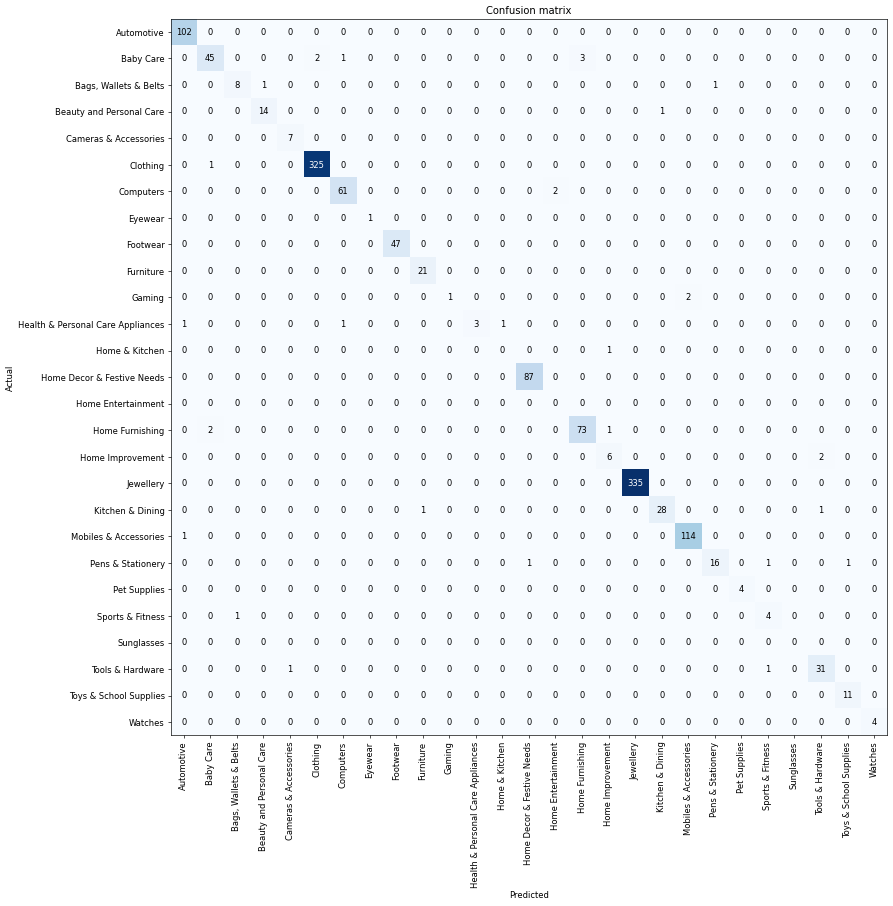

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

# ULMFiT using description, brand and product_name to predict main_category with threshold value=10

## Adding brand and product_name to the description

In [ ]:
for i in range(len(df_final)):
    df_final['description'].iloc[i] = "Product name is " + str(df_final['product_name'].iloc[i]) + " " + "Brand name is " + str(
        df_final['brand'].iloc[i]) + " " + str(df_final['description'].iloc[i])

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
1  Product name is FabHomeDecor Fabric Double Sof...  ...     Furniture
2  Product name is AW Bellies Brand name is AW Pr...  ...      Footwear
3  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
4  Product name is Sicons All Purpose Arnica Dog ...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations. 


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


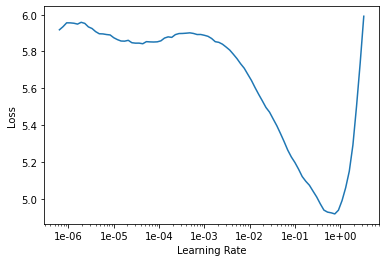

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12423 items)
x: LMTextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 7min 32s, sys: 5min 36s, total: 13min 8s
Wall time: 13min 16s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12423 items)
x: LMTextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12423 items)
x: TextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup alth

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


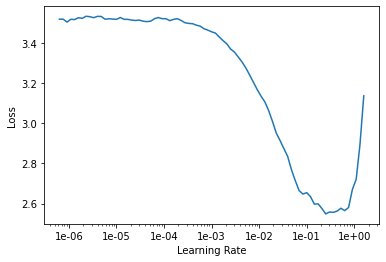

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

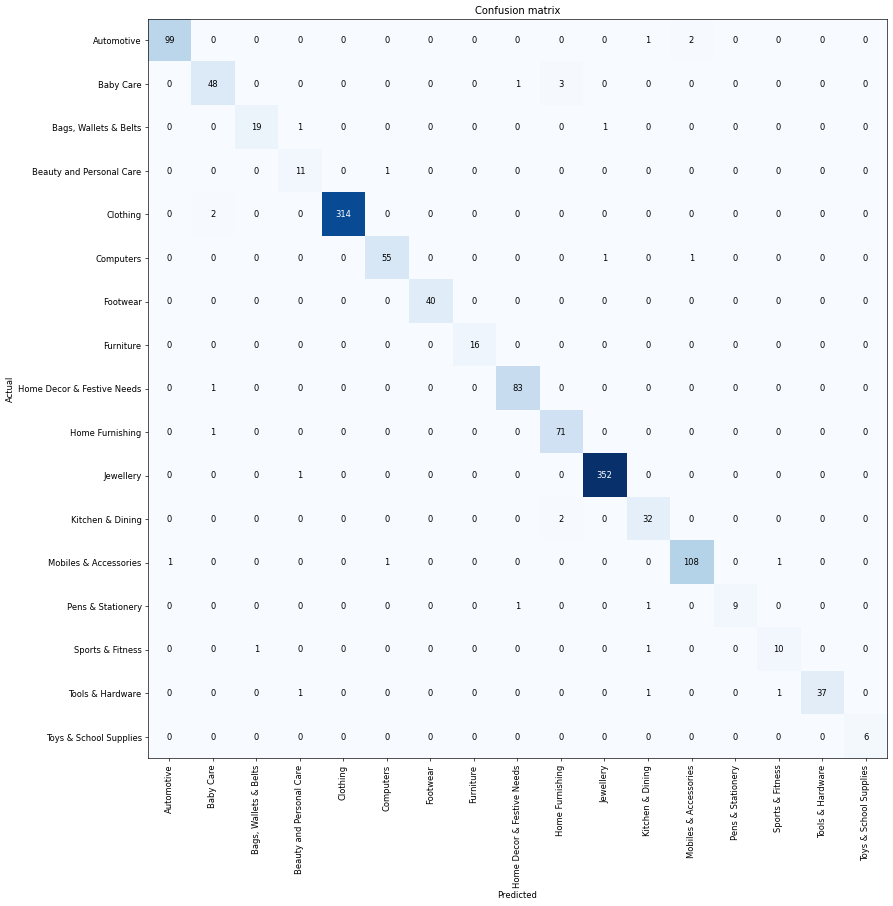

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

# ULMFiT using only description to predict main_category with threshold value=0 (Removing top cats)

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
list_top_cats = ['Jewellery', 'Clothing']
arr = []

for i in range(len(df_final)):
    if df_final['main_category'].iloc[i] in list_top_cats:
        arr.append(i)

print(arr)
df = df_final.drop(arr)

[0, 3, 6, 9, 11, 13, 15, 18, 21, 22, 26, 30, 32, 34, 54, 74, 81, 82, 83, 84, 85, 86, 87, 92, 94, 96, 100, 101, 111, 112, 114, 116, 117, 118, 127, 147, 152, 153, 154, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227, 228, 229, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 306, 307, 308, 309, 310, 311, 312, 313, 325, 329, 344, 357, 358, 361, 363, 364, 367, 370, 382, 385, 387, 388, 389, 390, 397, 400, 401, 402, 407, 410, 411, 414, 416, 417, 422, 425, 427, 429, 430, 431, 433, 436, 437, 438,

In [ ]:
df.shape

(7451, 8)

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
1  Product name is FabHomeDecor Fabric Double Sof...  ...     Furniture
2  Product name is AW Bellies Brand name is AW Ke...  ...      Footwear
3  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
4  Product name is Sicons All Purpose Arnica Dog ...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Amita Home Furnishing Cotton Printed Single Beds...", Dremel 2615.023.132 Plastic Friction Work Bench ...", Foot Candy Women Flats", SJ Comet Zoom DPSI Binoculars (30 mm, Black)", Cellbazaar Blackberry 8520 WHITE LCD LCD (YIT-562)"...
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


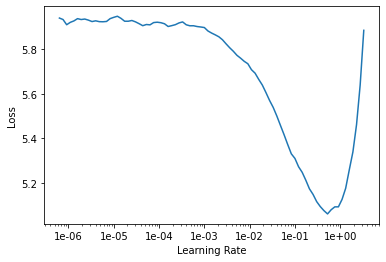

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12722 items)
x: LMTextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 17min 22s, sys: 13min 53s, total: 31min 16s
Wall time: 31min 31s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12722 items)
x: LMTextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12722 items)
x: TextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxma

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


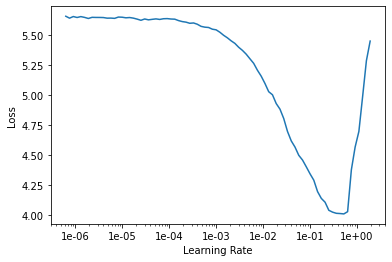

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

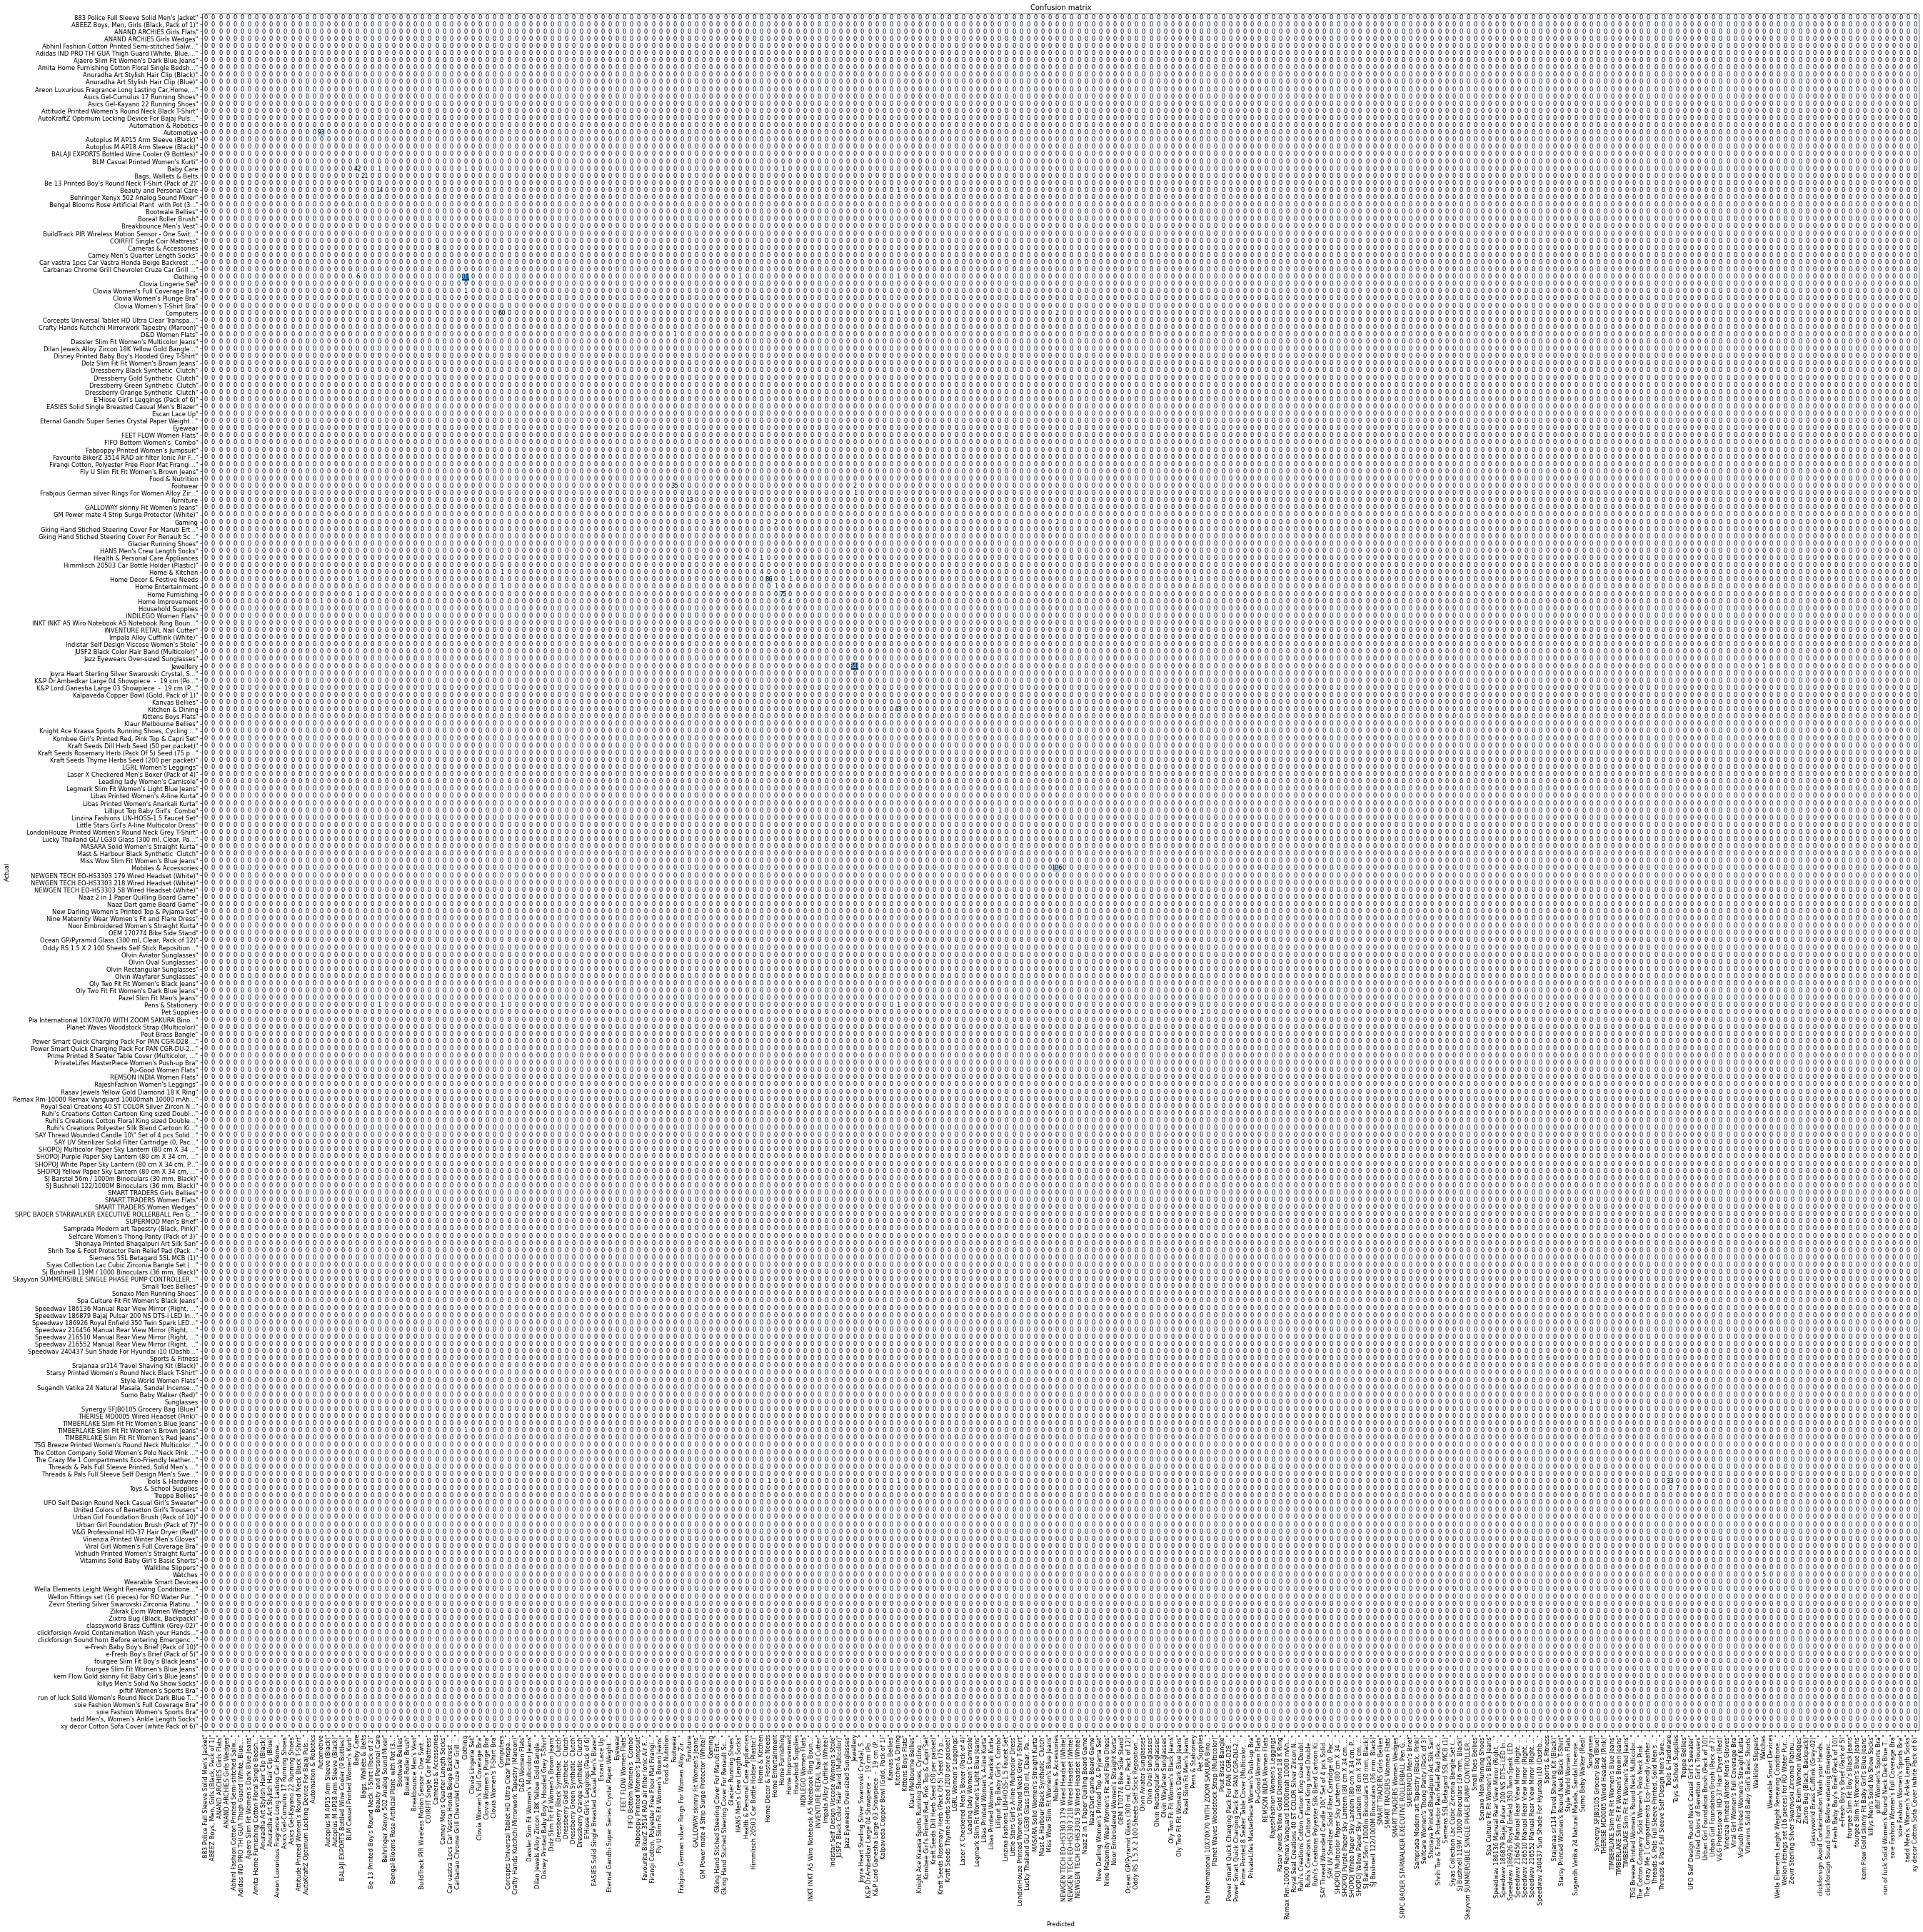

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(45, 45), dpi=60)

# ULMFiT using only description predict main_category with threshold value=10 (Removing top cats)

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
list_top_cats = ['Jewellery', 'Clothing']
arr = []

for i in range(len(df_final)):
    if df_final['main_category'].iloc[i] in list_top_cats:
        arr.append(i)

print(arr)
df = df_final.drop(arr)

[0, 3, 5, 8, 10, 12, 14, 17, 20, 21, 24, 28, 30, 32, 38, 51, 57, 58, 59, 60, 61, 62, 63, 68, 70, 72, 76, 77, 87, 88, 90, 92, 93, 94, 97, 102, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 180, 181, 182, 183, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 260, 261, 262, 263, 264, 265, 266, 267, 279, 283, 298, 311, 312, 315, 317, 318, 321, 324, 336, 339, 341, 342, 343, 344, 351, 354, 355, 356, 361, 364, 365, 368, 370, 371, 376, 379, 381, 383, 384, 385, 387, 390, 391, 392, 394, 396

In [ ]:
df.shape

(7119, 8)

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
1  FabHomeDecor Fabric Double Sofa Bed Finish Col...  ...     Furniture
2  Key Features AW Bellies Sandals Wedges Heel Ca...  ...      Footwear
3  Key Features Alisha Solid Women Cycling Shorts...  ...      Clothing
4  Specifications Sicons All Purpose Arnica Dog S...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


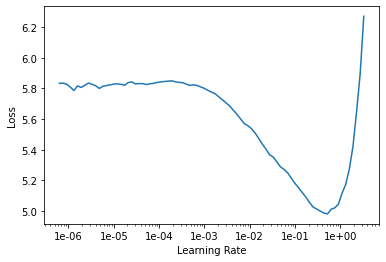

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12423 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 13min 30s, sys: 10min 36s, total: 24min 7s
Wall time: 24min 15s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12423 items)
x: LMTextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep sea

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12423 items)
x: TextList
xxbos xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


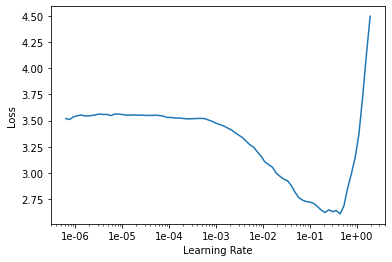

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

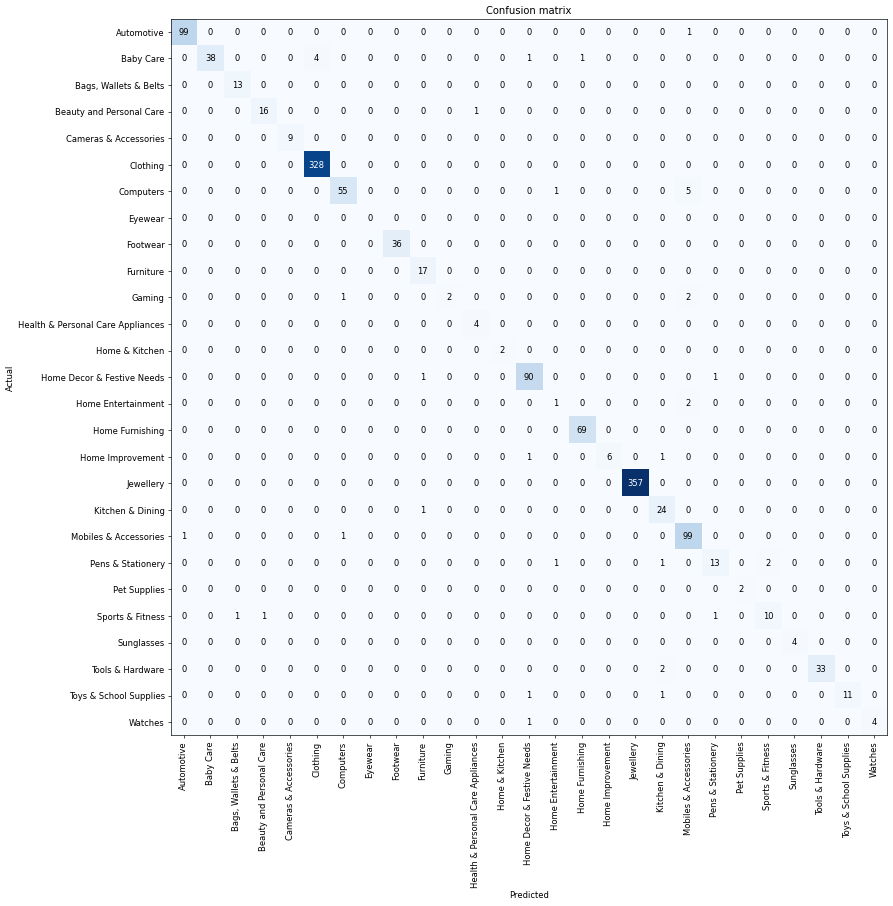

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

# ULMFiT using description, brand and product_name to predict main_category with threshold value=0 (Removing top cats)

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
list_top_cats = ['Jewellery', 'Clothing']
arr = []

for i in range(len(df_final)):
    if df_final['main_category'].iloc[i] in list_top_cats:
        arr.append(i)

print(arr)
df = df_final.drop(arr)

[0, 3, 6, 9, 11, 13, 15, 18, 21, 22, 26, 30, 32, 34, 54, 74, 81, 82, 83, 84, 85, 86, 87, 92, 94, 96, 100, 101, 111, 112, 114, 116, 117, 118, 127, 147, 152, 153, 154, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227, 228, 229, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 306, 307, 308, 309, 310, 311, 312, 313, 325, 329, 344, 357, 358, 361, 363, 364, 367, 370, 382, 385, 387, 388, 389, 390, 397, 400, 401, 402, 407, 410, 411, 414, 416, 417, 422, 425, 427, 429, 430, 431, 433, 436, 437, 438,

In [ ]:
df.shape

(7451, 8)

## Adding brand and product_name to the description

In [ ]:
for i in range(len(df_final)):
    df_final['description'].iloc[i] = "Product name is " + str(df_final['product_name'].iloc[i]) + " " + "Brand name is " + str(
        df_final['brand'].iloc[i]) + " " + str(df_final['description'].iloc[i])

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
1  Product name is FabHomeDecor Fabric Double Sof...  ...     Furniture
2  Product name is AW Bellies Brand name is AW Ke...  ...      Footwear
3  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
4  Product name is Sicons All Purpose Arnica Dog ...  ...  Pet Supplies

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Amita Home Furnishing Cotton Printed Single Beds...", Dremel 2615.023.132 Plastic Friction Work Bench ...", Foot Candy Women Flats", SJ Comet Zoom DPSI Binoculars (30 mm, Black)", Cellbazaar Blackberry 8520 WHITE LCD LCD (YIT-562)"...
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


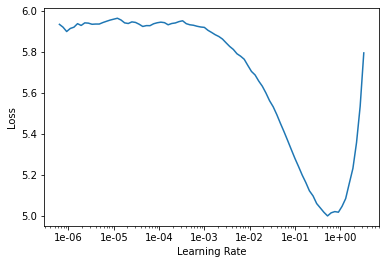

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12722 items)
x: LMTextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 17min 25s, sys: 14min, total: 31min 26s
Wall time: 31min 34s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12722 items)
x: LMTextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12722 items)
x: TextList
xxbos xxmaj product name is xxmaj alisha xxmaj solid xxmaj women 's xxmaj cycling xxmaj shorts xxmaj brand name is xxmaj alisha xxmaj key xxmaj features xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj cotton xxmaj lycra xxmaj navy xxmaj red xxmaj navy xxmaj specifications xxmaj alisha xxmaj solid xxmaj women xxmaj cycling xxmaj shorts xxmaj shorts xxmaj details xxmaj number xxmaj contents xxmaj sales xxmaj package xxmaj pack xxmaj fabric xxmaj cotton xxmaj lycra xxmaj type xxmaj cycling xxmaj shorts xxmaj general xxmaj details xxmaj pattern xxmaj solid xxmaj ideal xxmaj for xxmaj women xxmaj fabric xxmaj care xxmaj gentle xxmaj machine xxmaj wash xxmaj lukewarm xxmaj water xxmaj do xxmaj not xxmaj bleach xxmaj additional xxmaj details xxmaj style xxmaj code xxup altht p xxmaj in xxmaj box shorts,xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxma

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


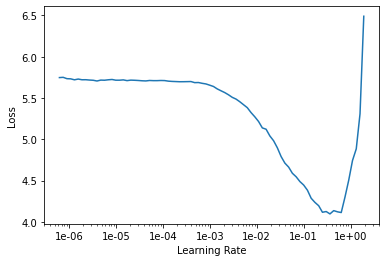

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

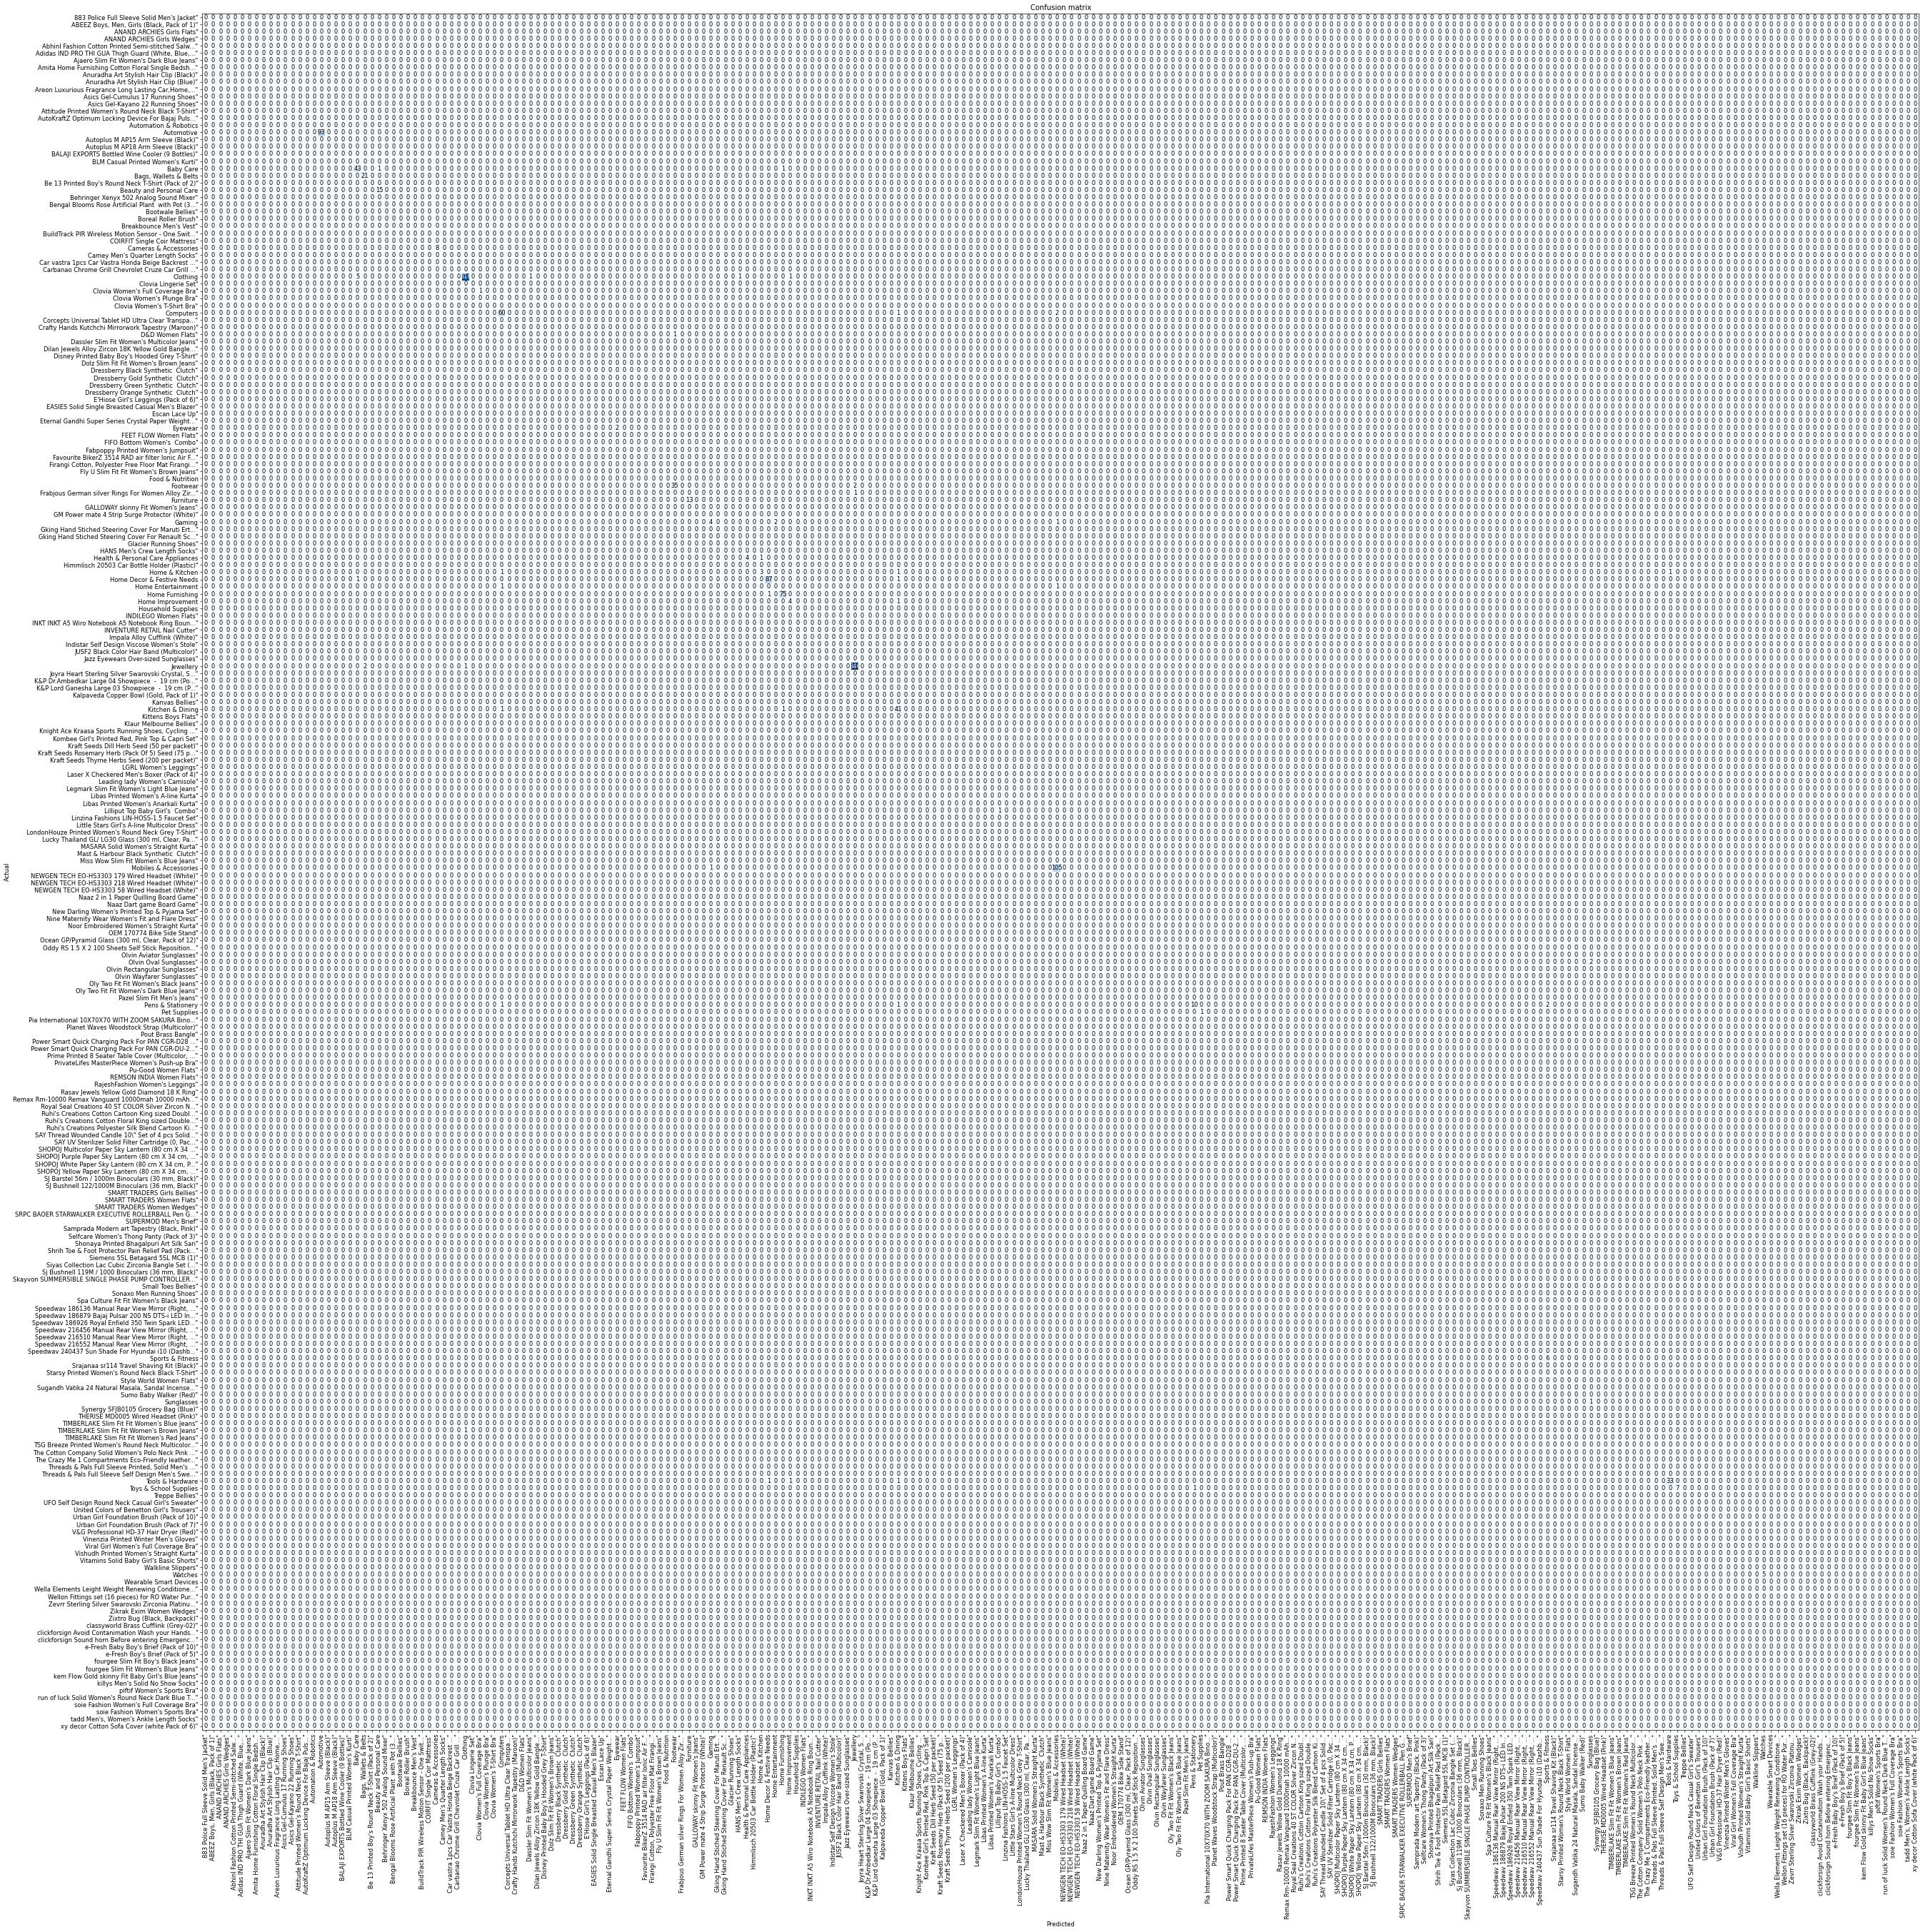

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(45, 45), dpi=60)

# ULMFiT using description, brand and product_name to predict main_category with threshold value=10 (Removing top cats)

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
list_top_cats = ['Jewellery', 'Clothing']
arr = []

for i in range(len(df_final)):
    if df_final['main_category'].iloc[i] in list_top_cats:
        arr.append(i)

print(arr)
df = df_final.drop(arr)

[2, 5, 7, 9, 11, 14, 17, 18, 21, 25, 27, 29, 35, 48, 54, 55, 56, 57, 58, 59, 60, 65, 67, 69, 73, 74, 84, 85, 87, 89, 90, 91, 94, 99, 103, 104, 105, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 177, 178, 179, 180, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 257, 258, 259, 260, 261, 262, 263, 264, 276, 280, 295, 308, 309, 312, 314, 315, 318, 321, 333, 336, 338, 339, 340, 341, 348, 351, 352, 353, 358, 361, 362, 365, 367, 368, 373, 376, 378, 380, 381, 382, 384, 387, 388, 389, 391, 393, 396, 39

In [ ]:
df.shape

(7118, 8)

## Adding brand and product_name to the description

In [ ]:
for i in range(len(df_final)):
    df_final['description'].iloc[i] = "Product name is " + str(df_final['product_name'].iloc[i]) + " " + "Brand name is " + str(
        df_final['brand'].iloc[i]) + " " + str(df_final['description'].iloc[i])

## Removing redundant columns

In [ ]:
df = df_final.copy()
df.drop(['product_category_tree', 'secondary_category',
         'tertiary_category', 'quaternary_category'], axis=1, inplace=True)

In [ ]:
df.head(5)

description  ... main_category
0  Product name is FabHomeDecor Fabric Double Sof...  ...     Furniture
1  Product name is Sicons All Purpose Arnica Dog ...  ...  Pet Supplies
2  Product name is Alisha Solid Women's Cycling S...  ...      Clothing
3  Product name is FabHomeDecor Fabric Double Sof...  ...     Furniture
4  Product name is dilli bazaaar Bellies, Corpora...  ...      Footwear

[5 rows x 4 columns]

## Preparing data for the language model and classification model

Before proceeding further, I have prepared the data for the language model and for the classification model separately.

---

I have created the data object with the data block API. Each line of the datablock is explained here: 
 - `(TextList.from_df(df, path , cols='description')` : Inputs: all the text files in path  
 - `.split_by_rand_pct(0.1,seed=42)` : We randomly split and keep 10% for validation
 - `.label_for_lm()` : We want to do a language model so we label accordingly

In [ ]:
# Language model data
data_lm = (TextList.from_df(df, path, cols='description')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Classifier model data
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='description')
             .split_by_rand_pct(0.1, seed=42)
             .label_from_df('main_category')
             .databunch(bs=bs, num_workers=1))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Fine-Tuning the Pre-Trained Model

I now use the data_lm object I created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

---

Why use AWD_LSTM architecture? 

The AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses DropConnect and a variant of Average-SGD (NT-ASGD) along with several other well-known regularization strategies. 

As discussed in the "My approach" section above, language modeling is found to be the ideal source task for learning the semantics of the language and using the encoder for other NLP tasks. Since, the AWD-LSTM has been dominating the state-of-the-art language modeling, it would be the right choice for our task at hand. It is also known that all the top research papers on word-level models incorporate AWD-LSTMs.

The research paper – [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182) introduced the AWD-LSTM architecture for the first time. The paper investigates a set of regularization and optimization strategies for word-based language modeling tasks highly effective. Moreover, they can also be used with no modification to existing LSTM implementations.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


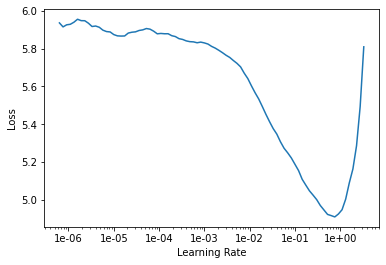

In [ ]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai, instead of using the `fit()` method, it is beneficial to use the `fit_one_cycle()` method, due to its better performance in speed and accuracy. In actuality, `fit_one_cycle()` is Fastai’s implementation of **Leslie Smith’s 1cycle policy**. 

Smith developed, refined and publicised his methodology over three research papers:

 - [Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)  
 - [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)](https://arxiv.org/abs/1708.07120)  
 - [A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay (2018)](https://arxiv.org/abs/1803.09820)

 ---

The momentum or `moms` used below while fitting one cycle, is the first beta in Adam (or the momentum in SGD/RMSProp). 

When you pass along (0.8,0.7) it implies going from 0.8 to 0.7 during the warmup and then from 0.7 to 0.8 in the annealing. However, it only changes the first beta in Adam.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12420 items)
x: LMTextList
xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating experience xxmaj save xxmaj space new click clack xxmaj sofa xxmaj bed xxmaj easy fold vice versa simple click clack mechanism xxmaj chrome legs mango wood frame long term durability xxmaj double cushioned xxmaj sofa xxmaj bed provide extra softness make fine seating experience a double bed easily sleep two xxmaj specifications fabhomedecor xxmaj fabric x

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

CPU times: user 9min 1s, sys: 6min 41s, total: 15min 43s
Wall time: 15min 52s


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12420 items)
x: LMTextList
xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating experience xxmaj save xxmaj space new click clack xxmaj sofa xxmaj bed xxmaj easy fold vice versa simple click clack mechanism xxmaj chrome legs mango wood frame long term durability xxmaj double cushioned xxmaj sofa xxmaj bed provide extra softness make fine seating experience a double bed easily sleep two xxmaj specifications fabhomedecor xxmaj fabric x

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('final_enc1')

## Training the classifier

Now I used the data_clas object I created earlier to build a classifier with the fine-tuned encoder that was saved in the previous step.

---

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM)
learn.load_encoder('final_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12420 items)
x: TextList
xxbos xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor xxmaj product name is fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj brand name is fabhomedecor fabhomedecor xxmaj fabric xxmaj double xxmaj sofa xxmaj bed xxmaj finish xxmaj color xxmaj leatherette xxmaj black xxmaj mechanism xxmaj type xxmaj pull xxmaj out xxmaj price xxmaj rs xxmaj fine deep seating experience xxmaj save xxmaj space new click clack xxmaj sofa xxmaj bed xxmaj easy fold vice versa simple click clack mechanism xxmaj chrome legs mango wood frame long term durability xxmaj double cushioned xxmaj sofa xxmaj bed provide extra softness make fine seating experience a double bed easily sleep two xxmaj specifications fabhomedecor xxmaj fabric xxmaj 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


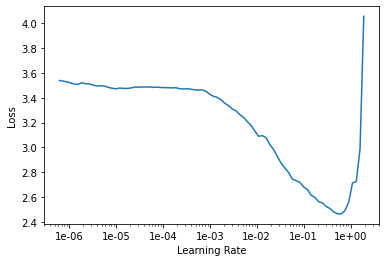

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

## Interpreting the model with a confusion matrix

I now found the predictions for the validation set out of the learner object by using the below code:

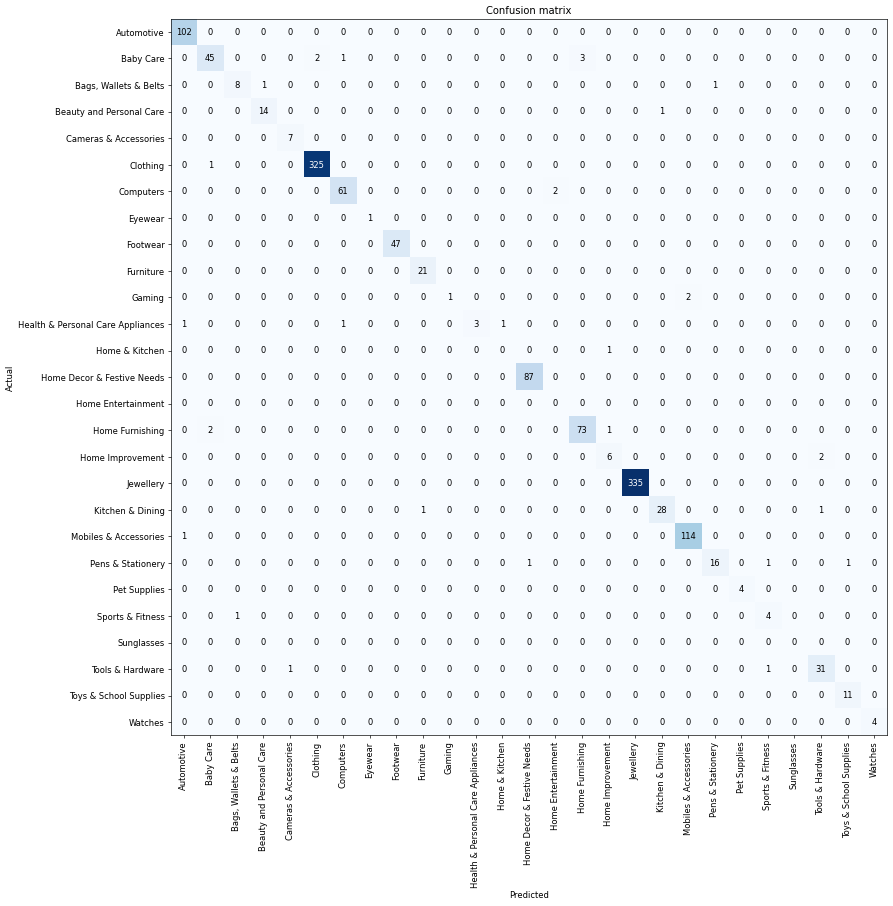

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds) == len(losses) == len(idxs)

interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

# Results

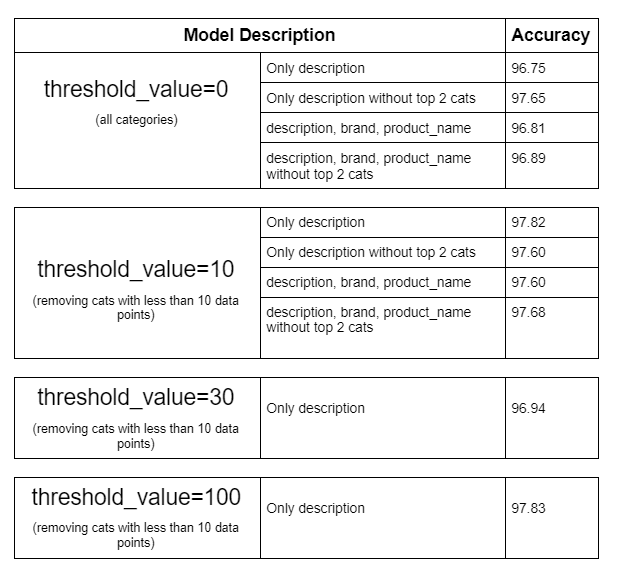

# Future Scope

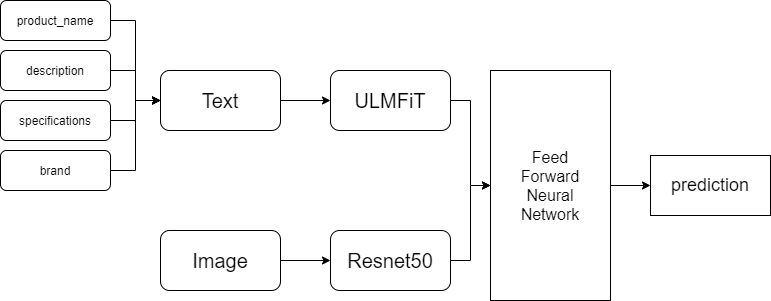

In future, the architecture implemented in this project can be extended by taking in account the predictions from the images as well (refer to the above diagram). Due to time constraints, I was unable to implement it. 

Another way to approach this challenge would be to use machine translation as shown in [this paper](https://arxiv.org/pdf/1812.05774.pdf). this method helps in predicting the whole category tree. It shows that state-of-the-art machine translation (MT) models surpass previous classification approaches in categorizing products in two large real-world e-commerce datasets. Moreover, novel roof-to-leaf category paths are found by using NMT models.

# References

 - Howard, J. and Sebastian Ruder. “Universal Language Model Fine-tuning for Text Classification.” ACL (2018).

 - Merity, Stephen, N. Keskar and R. Socher. “Regularizing and Optimizing LSTM Language Models.” ArXiv abs/1708.02182 (2018): n. pag.

 - Li, M., Stanley Kok and Liling Tan. “Don't Classify, Translate: Multi-Level E-Commerce Product Categorization Via Machine Translation.” ArXiv abs/1812.05774 (2018): n. Pag.

 - Cevahir, A. and Murakami, K. (2016). Large-scale multi-class and hierarchical product categorization for an e-commerce giant. In Proceedings of COLING 2016, the 26th International Conference on Computational Linguistics: Technical Papers, pages 525–535. 

 - Ha, J.-W., Pyo, H., and Kim, J. (2016). Large-scale item categorization in e-commerce using multiple recurrent neural networks. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pages 107–115. ACM.

 - Wirojwatanakul, Pasawee and A. Wangperawong. “Multi-Label Product Categorization Using Multi-Modal Fusion Models.” ArXiv abs/1907.00420 (2019): n. pag.

 - Seth, Y. (2018, November 30). What makes the AWD-LSTM great? Retrieved April 10, 2021, from https://yashuseth.blog/2018/09/12/awd-lstm-explanation-understanding-language-model/

 - Ravi, A. (2020, May 31). Understanding ULMFiT - the shift Towards transfer learning in NLP. Retrieved April 10, 2021, from https://towardsdatascience.com/understanding-ulmfit-and-elmo-the-shift-towards-transfer-learning-in-nlp-b5d8e2e3f664

 - Kostas. (n.d.). Understanding Fastai's Fit_one_cycle method. Retrieved April 10, 2021, from https://iconof.com/1cycle-learning-rate-policy/

 - /author/sylvain-Gugger.html. (2018, April 07). The 1cycle policy. Retrieved April 10, 2021, from https://sgugger.github.io/the-1cycle-policy.html

 - Smith, Leslie N.. “Cyclical Learning Rates for Training Neural Networks.” 2017 IEEE Winter Conference on Applications of Computer Vision (WACV) (2017): 464-472.

 - Smith, Leslie N. and Nicholay Topin. “Super-convergence: very fast training of neural networks using large learning rates.” Defense + Commercial Sensing (2019).

 - Smith, Leslie N.. “A disciplined approach to neural network hyper-parameters: Part 1 - learning rate, batch size, momentum, and weight decay.” ArXiv abs/1803.09820 (2018): n. pag.